# import


In [7]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


1.12.1+cu113
0.13.1+cu113
True


In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import albumentations as A
import random

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [9]:
!nvidia-smi

Sat Oct 15 09:29:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    41W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
!pip install --upgrade albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# data

!gdown --id 1rZX15GYUJ44kEiuZOPUL4quOjcqwi-f5 --output documents.zip
!unzip -q documents.zip
!ls

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import shutil
shutil.copytree('/content/data_coco','/content/drive/MyDrive/Lesion_detection/data_coco')

'/content/drive/MyDrive/Lesion_detection/data_coco'

In [13]:
import os
import zipfile

ZIP_PATH='/content/drive/MyDrive/Lesion_detection/lesion_data_small.zip'
UNZIP_PATH='/content/'

# 전체를 압축해제 하고 싶을 때
zipfile.ZipFile(ZIP_PATH).extractall(UNZIP_PATH)


In [24]:
# split_data.py

from glob import glob
import shutil
import os
import random

load_dir = '/content/lesion_data_small'
save_dir = '/content/data_split'

files = glob('%s/train/*.json' % load_dir)
random.shuffle(files)

if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

shutil.copyfile('%s/class_id_info.csv' % load_dir, "%s/class_id_info.csv" % save_dir)
shutil.copyfile('%s/sample_submission.csv' % load_dir, "%s/sample_submission.csv" % save_dir)
shutil.copytree("%s/test" % load_dir, "%s/test" % save_dir)

num_all = len(files)
num_valid = round(0.1 * num_all)

ind = 0
for file in files:
    if ind < num_all - num_valid:
        shutil.copyfile(file, "%s/train/%s" % (save_dir, os.path.basename(file)))
    else:
        shutil.copyfile(file, "%s/valid/%s" % (save_dir, os.path.basename(file)))
    ind += 1
    


In [25]:
# convert_to_coco.py
# basic setup
import numpy as np
import json
import base64
import os
import random
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

from collections import defaultdict

#base_dir = '/home/ubuntu/lesionData/data_split'
#save_dir = "/home/ubuntu/lesionData/data_coco"

#base_dir = 'C:/A/lesionData/data_split'
#save_dir = "C:/A/lesionData/data_coco"

base_dir = '/content/data_split'
save_dir = "/content/data_coco"


def convert_to_coco(
    json_paths, # 변경
    save_path,
    save_folder,
):
    """
        only for train dataset
    """
    res = defaultdict(list)
    # 제거
    # json_paths = glob(os.path.join(root_path, 'train', '*.json'))
    categories = {
        '01_ulcer': 1,
        '02_mass': 2,
        '04_lymph': 3,
        '05_bleeding': 4
    }
    
    n_id = 0
    for json_path in tqdm(json_paths):
        with open(json_path, 'r') as f:
            tmp = json.load(f)

        # [추가] train image 저장
        image = BytesIO(base64.b64decode(tmp['imageData']))
        image = Image.open(image).convert('RGB')
        
        image.save(os.path.join(save_dir, save_folder, tmp['file_name'].split(".")[0]+".jpg"))
        
        image_id = int(tmp['file_name'].split('_')[-1][:6])
        res['images'].append({
            'id': image_id,
            'width': tmp['imageWidth'],
            'height': tmp['imageHeight'],
            'file_name': tmp['file_name'].split(".")[0]+".jpg", # 변경
        })
        
        for shape in tmp['shapes']:
            box = np.array(shape['points']) # 추가
            x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
            
            w, h = x2 - x1, y2 - y1
            
            res['annotations'].append({
                'id': n_id,
                'image_id': image_id,
                'category_id': categories[shape['label']],
                'area': w * h,
                'bbox': [x1, y1, x2, y2],
                'iscrowd': 0,
            })
            n_id += 1
    
    for name, id in categories.items():
        res['categories'].append({
            'id': id,
            'name': name,
        })
        
    with open(save_path, 'w') as f:
        json.dump(res, f)
        
save_path_dir = os.path.join(save_dir, "train")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)
    
save_path_dir = os.path.join(save_dir, "valid")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

    
random.seed(10)

train_file = glob(os.path.join(base_dir, 'train/*.json'))
valid_file = glob(os.path.join(base_dir, 'valid/*.json'))

convert_to_coco(train_file, os.path.join(save_dir, 'train_annotations.json'), 'train')
convert_to_coco(valid_file, os.path.join(save_dir, 'valid_annotations.json'), 'valid')


##################################test################################################
test_files = sorted(glob(os.path.join(base_dir, 'test/*')))


test_json_list = []
for file in tqdm(test_files):
    with open(file, "r") as json_file:
        test_json_list.append(json.load(json_file))
        
save_path_dir = os.path.join(save_dir, "test")
if not os.path.exists(save_path_dir):
    os.makedirs(save_path_dir)

for sample in tqdm(test_json_list):
    
    image_id = sample['file_name'].split(".")[0]
    image = BytesIO(base64.b64decode(sample['imageData']))
    image = Image.open(image).convert('RGB')
    
    image.save(os.path.join(save_dir,"test",image_id+".jpg"))


100%|██████████| 200/200 [00:02<00:00, 79.48it/s]


In [27]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore")


DIR_INPUT = '/content/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VAILD = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'


In [28]:
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [92]:
import json

file_path = DIR_INPUT+"/train_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())


dict_keys(['images', 'annotations', 'categories'])


In [93]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))


900
1151
4


In [94]:
import pandas as pd

train_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    image_id=dic['image_id']
    category_id=dic['category_id']
    train_dic['image_id'].append(image_id)
    train_dic['class_id'].append(category_id)

    if category_id == 1:
        train_dic['class_name'].append('01_ulcer')
    elif category_id == 2:
        train_dic['class_name'].append('02_mass')
    elif category_id == 3:
        train_dic['class_name'].append('04_lymph')
    else:
        train_dic['class_name'].append('05_bleeding')            
        
    train_dic['x_min'].append(round(dic['bbox'][0],4))
    train_dic['y_min'].append(round(dic['bbox'][1],4))
    train_dic['x_max'].append(round(dic['bbox'][2],4))
    train_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == image_id:
           train_dic['width'].append(dic2['width'])
           train_dic['height'].append(dic2['height'])
           train_dic['file_name'].append(dic2['file_name'])

    
    
train_df=pd.DataFrame(train_dic)    


1151it [00:00, 6904.07it/s]


In [95]:
train_df

image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1151 rows x 10 columns]

In [96]:
DIR_INPUT = '/content/data_coco'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'
import os
import cv2
import json
import shutil
import base64
import random
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import Dict, List
import matplotlib.pyplot as plt
from collections import defaultdict


In [97]:
import json

file_path = DIR_INPUT+"/valid_annotations.json"

with open(file_path, 'r') as file:
    data = json.load(file)

print(data.keys())


dict_keys(['images', 'annotations', 'categories'])


In [98]:
print(len(data['images']))
print(len(data['annotations']))
print(len(data['categories']))


100
121
4


In [115]:
import pandas as pd
# [{'id': 148662, 'width': 320, 'height': 320, 'file_name': 'train_148662.jpg'},

valid_dic={
    'image_id':[],
    'class_name':[],
    'class_id':[],
    'x_min':[],
    'y_min':[],
    'x_max':[],
    'y_max':[],
    'width':[],
    'height':[],
    'file_name':[]
}

for i,dic in tqdm(enumerate(data['annotations'])):
    image_id=dic['image_id']
    category_id = dic['category_id']
    valid_dic['image_id'].append(image_id)
    valid_dic['class_id'].append(category_id)
    if category_id == 1:
        valid_dic['class_name'].append('01_ulcer')
    elif category_id == 2:
        valid_dic['class_name'].append('02_mass')
    elif category_id == 3:
        valid_dic['class_name'].append('04_lymph')
    else:
        valid_dic['class_name'].append('05_bleeding')            
    valid_dic['x_min'].append(round(dic['bbox'][0],4))
    valid_dic['y_min'].append(round(dic['bbox'][1],4))
    valid_dic['x_max'].append(round(dic['bbox'][2],4))
    valid_dic['y_max'].append(round(dic['bbox'][3],4))
    
    for k,dic2 in enumerate(data['images']):
      if dic2['id'] == image_id:
           valid_dic['width'].append(dic2['width'])
           valid_dic['height'].append(dic2['height'])
           valid_dic['file_name'].append(dic2['file_name'])

    
    
valid_df=pd.DataFrame(valid_dic)    


121it [00:00, 46887.54it/s]


In [116]:
train_df = train_df[train_df['x_max']<train_df['width']]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [117]:
train_df = train_df[train_df['x_min']>0]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [118]:
train_df = train_df[train_df['y_min']>0]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [119]:
train_df = train_df[train_df['y_max']<train_df['height']]
train_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [120]:
valid_df = valid_df[valid_df['x_max']<valid_df['width']]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [121]:
valid_df = valid_df[valid_df['x_min']>0]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [122]:
valid_df = valid_df[valid_df['y_max']<valid_df['height']]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [123]:
valid_df = valid_df[valid_df['y_min']>0]
valid_df


image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0      122348      02_mass         2  365.0206  162.0741  543.6214  355.4897   
1      122348     01_ulcer         1  143.4444  209.3333  310.5556  413.7778   
2      161027     01_ulcer         1  468.6923  276.9231  510.7041  336.0947   
3      158267  05_bleeding         4  197.5904  206.9157  260.2410  262.3373   
4      110855     04_lymph         3  127.3077   86.7788  173.9423  115.3846   
..        ...          ...       ...       ...       ...       ...       ...   
116    146889     01_ulcer         1  127.8943  116.2996  272.3877  274.8899   
117    146889     01_ulcer         1   82.0705  246.2555  238.4670  480.6167   
118    120676     01_ulcer         1  409.0712  287.7241  535.2781  438.0690   
119    140503  05_bleeding         4  380.6108  371.8563  430.3114  461.6766   
120    148113     01_ulcer         1   32.6316  154.6053  335.2632  351.9737   

     width  height         file_name  
0      576     576  train_122348.jpg  
1      576     576  train_122348.jpg  
2      576     576  train_161027.jpg  
3      576     576  train_158267.jpg  
4      320     320  train_110855.jpg  
..     ...     ...               ...  
116    576     576  train_146889.jpg  
117    576     576  train_146889.jpg  
118    576     576  train_120676.jpg  
119    576     576  train_140503.jpg  
120    576     576  train_148113.jpg  

[121 rows x 10 columns]

In [124]:
# train_df 전체 데이터 정보 저장하기
train_df.to_csv(f'{DIR_INPUT}/train.csv')


In [125]:
# valid_df 전체 데이터 정보 저장하기
valid_df.to_csv(f'{DIR_INPUT}/valid.csv')


In [127]:
import shutil
shutil.copytree('/content/data_coco','/content/drive/MyDrive/Lesion_detection/small_data_coco_1')

'/content/drive/MyDrive/Lesion_detection/small_data_coco_1'

# 함수

In [179]:
# 박스 색깔
BOX_COLOR = (255, 0, 0)

# 박스 보여주기 함수
def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

In [180]:
# 이미지 보여주기
def show_image(image, bbox):
  image = visualize_bbox(image.copy(), bbox)
  f = plt.figure(figsize=(18, 12))
  plt.imshow(
    cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    interpolation='nearest'
  )
  plt.axis('off')
  f.tight_layout()
  plt.show()

In [181]:
train_df

image_id   class_name  class_id     x_min     y_min     x_max     y_max  \
0       124374  05_bleeding         4  149.3976   32.8193  239.7590   71.9759   
1       119466     04_lymph         3   41.2208  182.6840  191.4372  496.5368   
2       160622     04_lymph         3  437.9286  150.0000  470.0714  235.1190   
3       146948     01_ulcer         1  344.2381  195.6114  531.2332  418.6984   
4       146246      02_mass         2  374.4979  110.8787  542.2803  241.0042   
...        ...          ...       ...       ...       ...       ...       ...   
1146    111675  05_bleeding         4   33.7778  267.5556  120.4444  408.8889   
1147    120338     01_ulcer         1  347.7879   36.3636  502.7662  175.7576   
1148    153383     04_lymph         3   92.0233  455.8295  169.5426  503.8915   
1149    106065     01_ulcer         1  312.0909  384.8485  393.0433  481.8182   
1150    143822     01_ulcer         1  213.5526   31.5789  412.8947  133.5526   

      width  height         file_name  
0       576     576  train_124374.jpg  
1       576     576  train_119466.jpg  
2       576     576  train_160622.jpg  
3       576     576  train_146948.jpg  
4       576     576  train_146246.jpg  
...     ...     ...               ...  
1146    576     576  train_111675.jpg  
1147    576     576  train_120338.jpg  
1148    576     576  train_153383.jpg  
1149    576     576  train_106065.jpg  
1150    576     576  train_143822.jpg  

[1149 rows x 10 columns]

In [182]:
mass_df=train_df[train_df['class_id']==2]

In [183]:
mass_df

image_id class_name  class_id     x_min     y_min     x_max     y_max  \
4       146246    02_mass         2  374.4979  110.8787  542.2803  241.0042   
6       159910    02_mass         2   33.5946   40.8108  273.0541  360.2703   
7       138037    02_mass         2  336.0000  324.4000  523.2000  483.6000   
9       116776    02_mass         2  119.3723  366.0996  228.8961  466.9654   
10      113157    02_mass         2  157.3333  343.5294  214.6863  418.5294   
...        ...        ...       ...       ...       ...       ...       ...   
1117    102432    02_mass         2  195.0962  103.6058  274.9038  164.1827   
1122    105599    02_mass         2  134.4934  329.9559  212.4670  392.5110   
1124    157316    02_mass         2  107.0866   39.9055  188.9764  132.8189   
1130    160400    02_mass         2   30.8756   34.3871  452.9954  471.7143   
1131    110448    02_mass         2  165.0000  252.4444  266.7778  352.8889   

      width  height         file_name  
4       576     576  train_146246.jpg  
6       576     576  train_159910.jpg  
7       576     576  train_138037.jpg  
9       576     576  train_116776.jpg  
10      576     576  train_113157.jpg  
...     ...     ...               ...  
1117    320     320  train_102432.jpg  
1122    576     576  train_105599.jpg  
1124    576     576  train_157316.jpg  
1130    576     576  train_160400.jpg  
1131    576     576  train_110448.jpg  

[148 rows x 10 columns]

In [184]:
for i,k in enumerate(mass_df.iloc):
  if(i==3): break
  print(i,k[3:7],k['file_name'])  

0 x_min    374.4979
y_min    110.8787
x_max    542.2803
y_max    241.0042
Name: 4, dtype: object train_146246.jpg
1 x_min     33.5946
y_min     40.8108
x_max    273.0541
y_max    360.2703
Name: 6, dtype: object train_159910.jpg
2 x_min    336.0
y_min    324.4
x_max    523.2
y_max    483.6
Name: 7, dtype: object train_138037.jpg


In [221]:
# 예시 그림과 bb box
file_name= mass_df.iloc[0]['file_name']
DIR_TRAIN = '/content/data_coco/train/'
print(DIR_TRAIN+file_name)
form = cv2.imread(DIR_TRAIN+file_name)
#BBOX = [140, 260, 300, 300]
BBox= []
BBox.append(float(mass_df.iloc[0]['x_min']))
BBox.append(float(mass_df.iloc[0]['y_min']))
BBox.append(float(mass_df.iloc[0]['x_max']))
BBox.append(float(mass_df.iloc[0]['y_max']))
print(BBox)

/content/data_coco/train/train_146246.jpg
[374.4979, 110.8787, 542.2803, 241.0042]


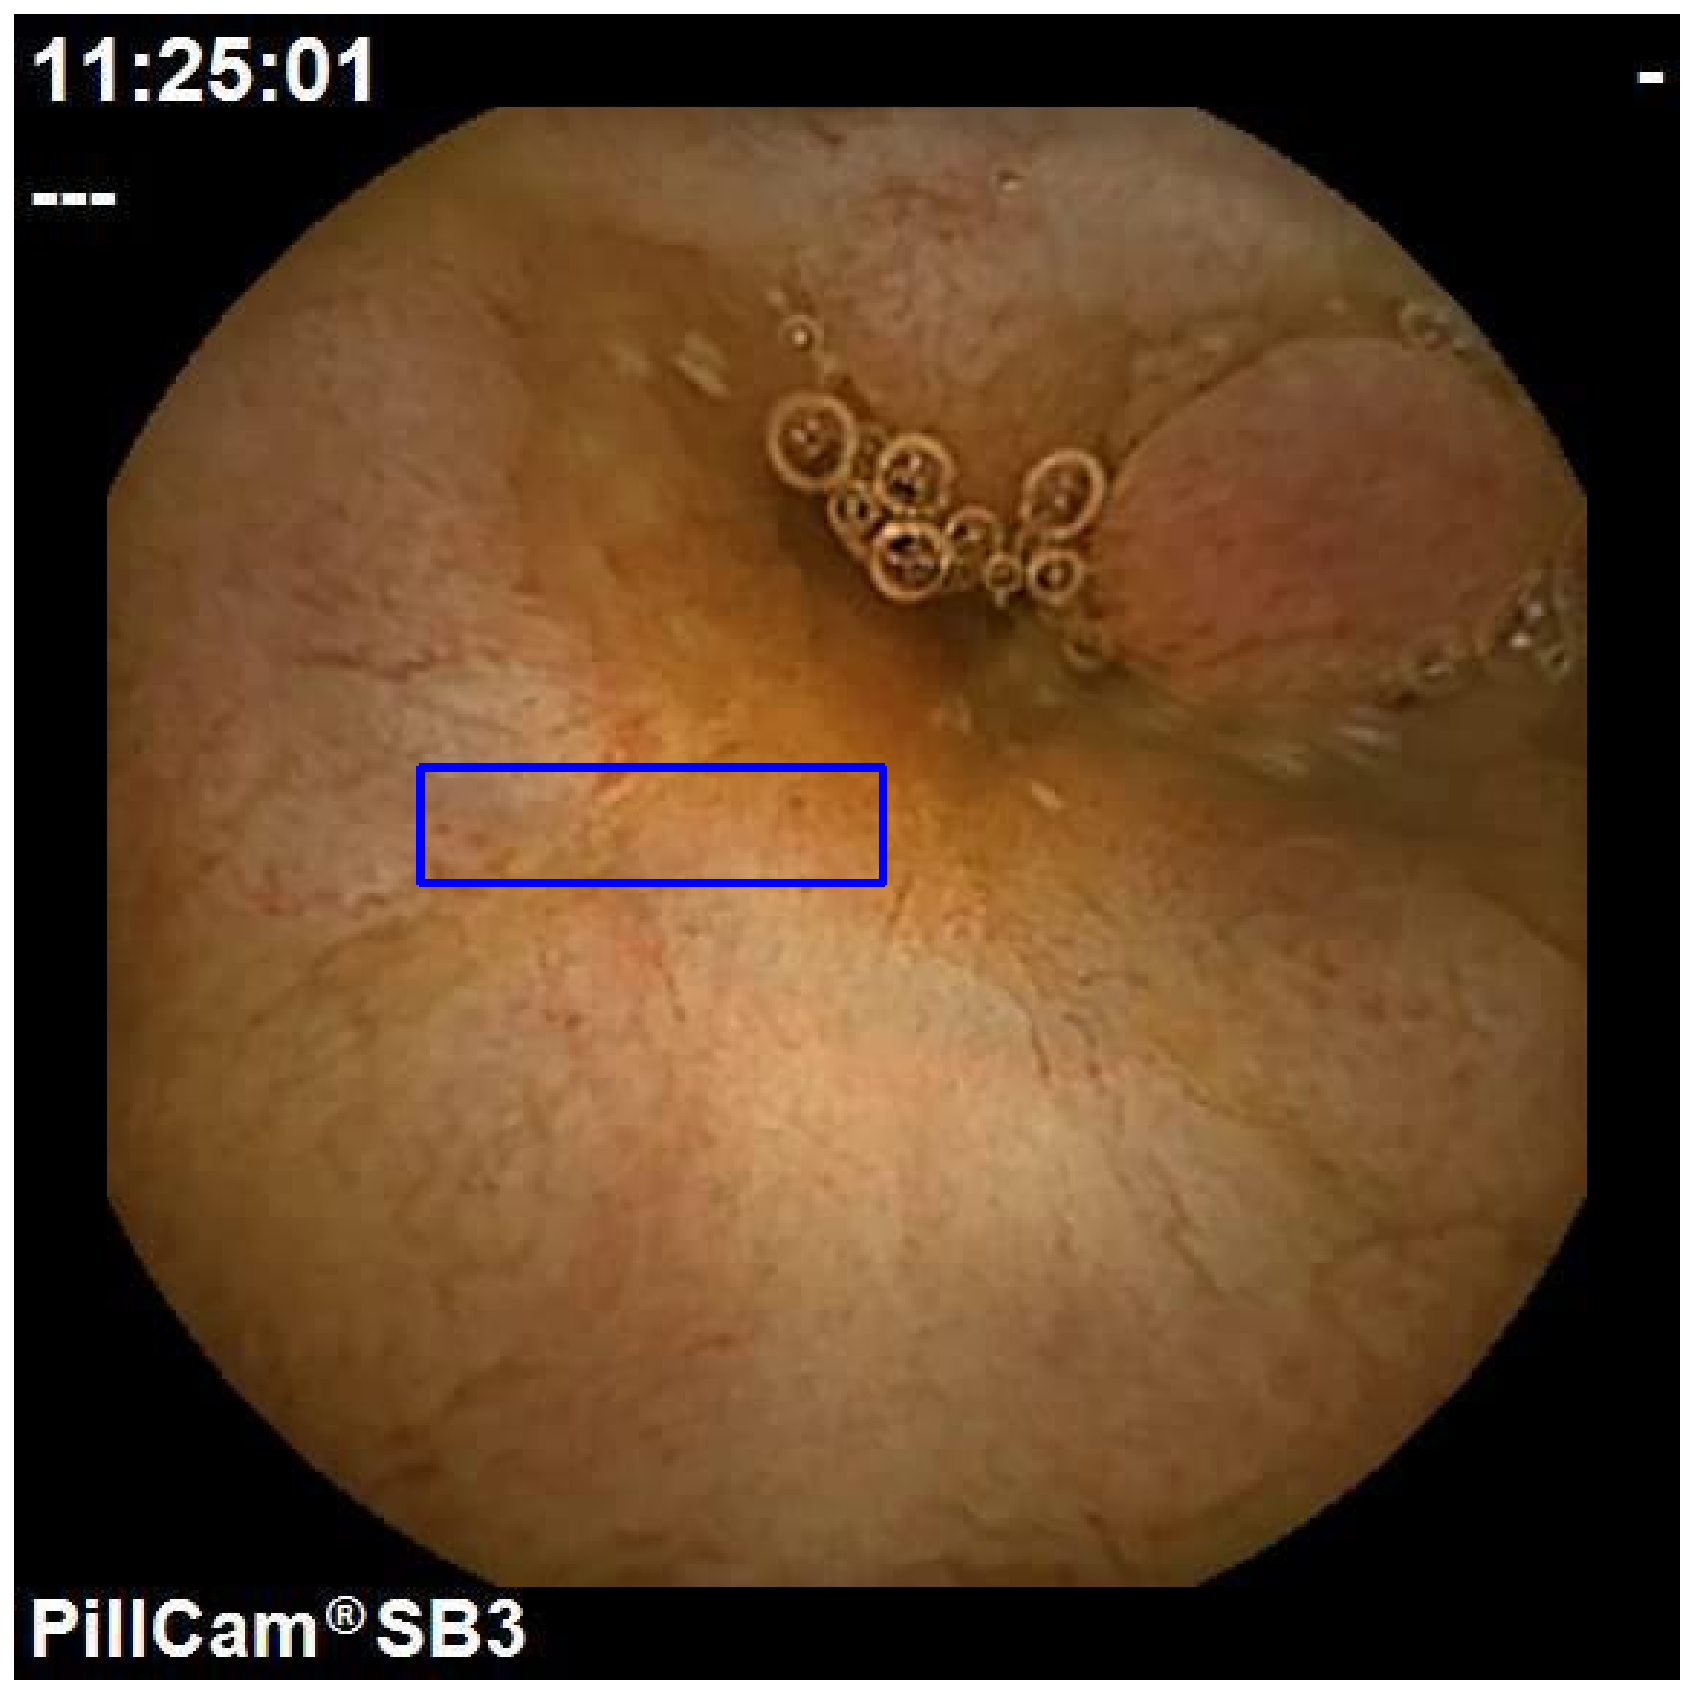

In [222]:
show_image(form, bbox=BBOX)

In [217]:
# 증강 보여주깅
def show_augmented(augmentation, image, bbox):
  # 증강 함수 틀
  augmented = augmentation(image=image, bboxes=[bbox], field_id=['1'])
  # 이미지 보여주는 함수
  show_image(augmented['image'], augmented['bboxes'][0])

In [218]:
# bbox 증강
# [x_min, y_min, x_max, y_max], e.g. [97, 12, 247, 212].
bbox_params = A.BboxParams(
  format='pascal_voc', 
  min_area=1, 
  min_visibility=0.5, 
  label_fields=['field_id']
)

# Exploring Augmentations

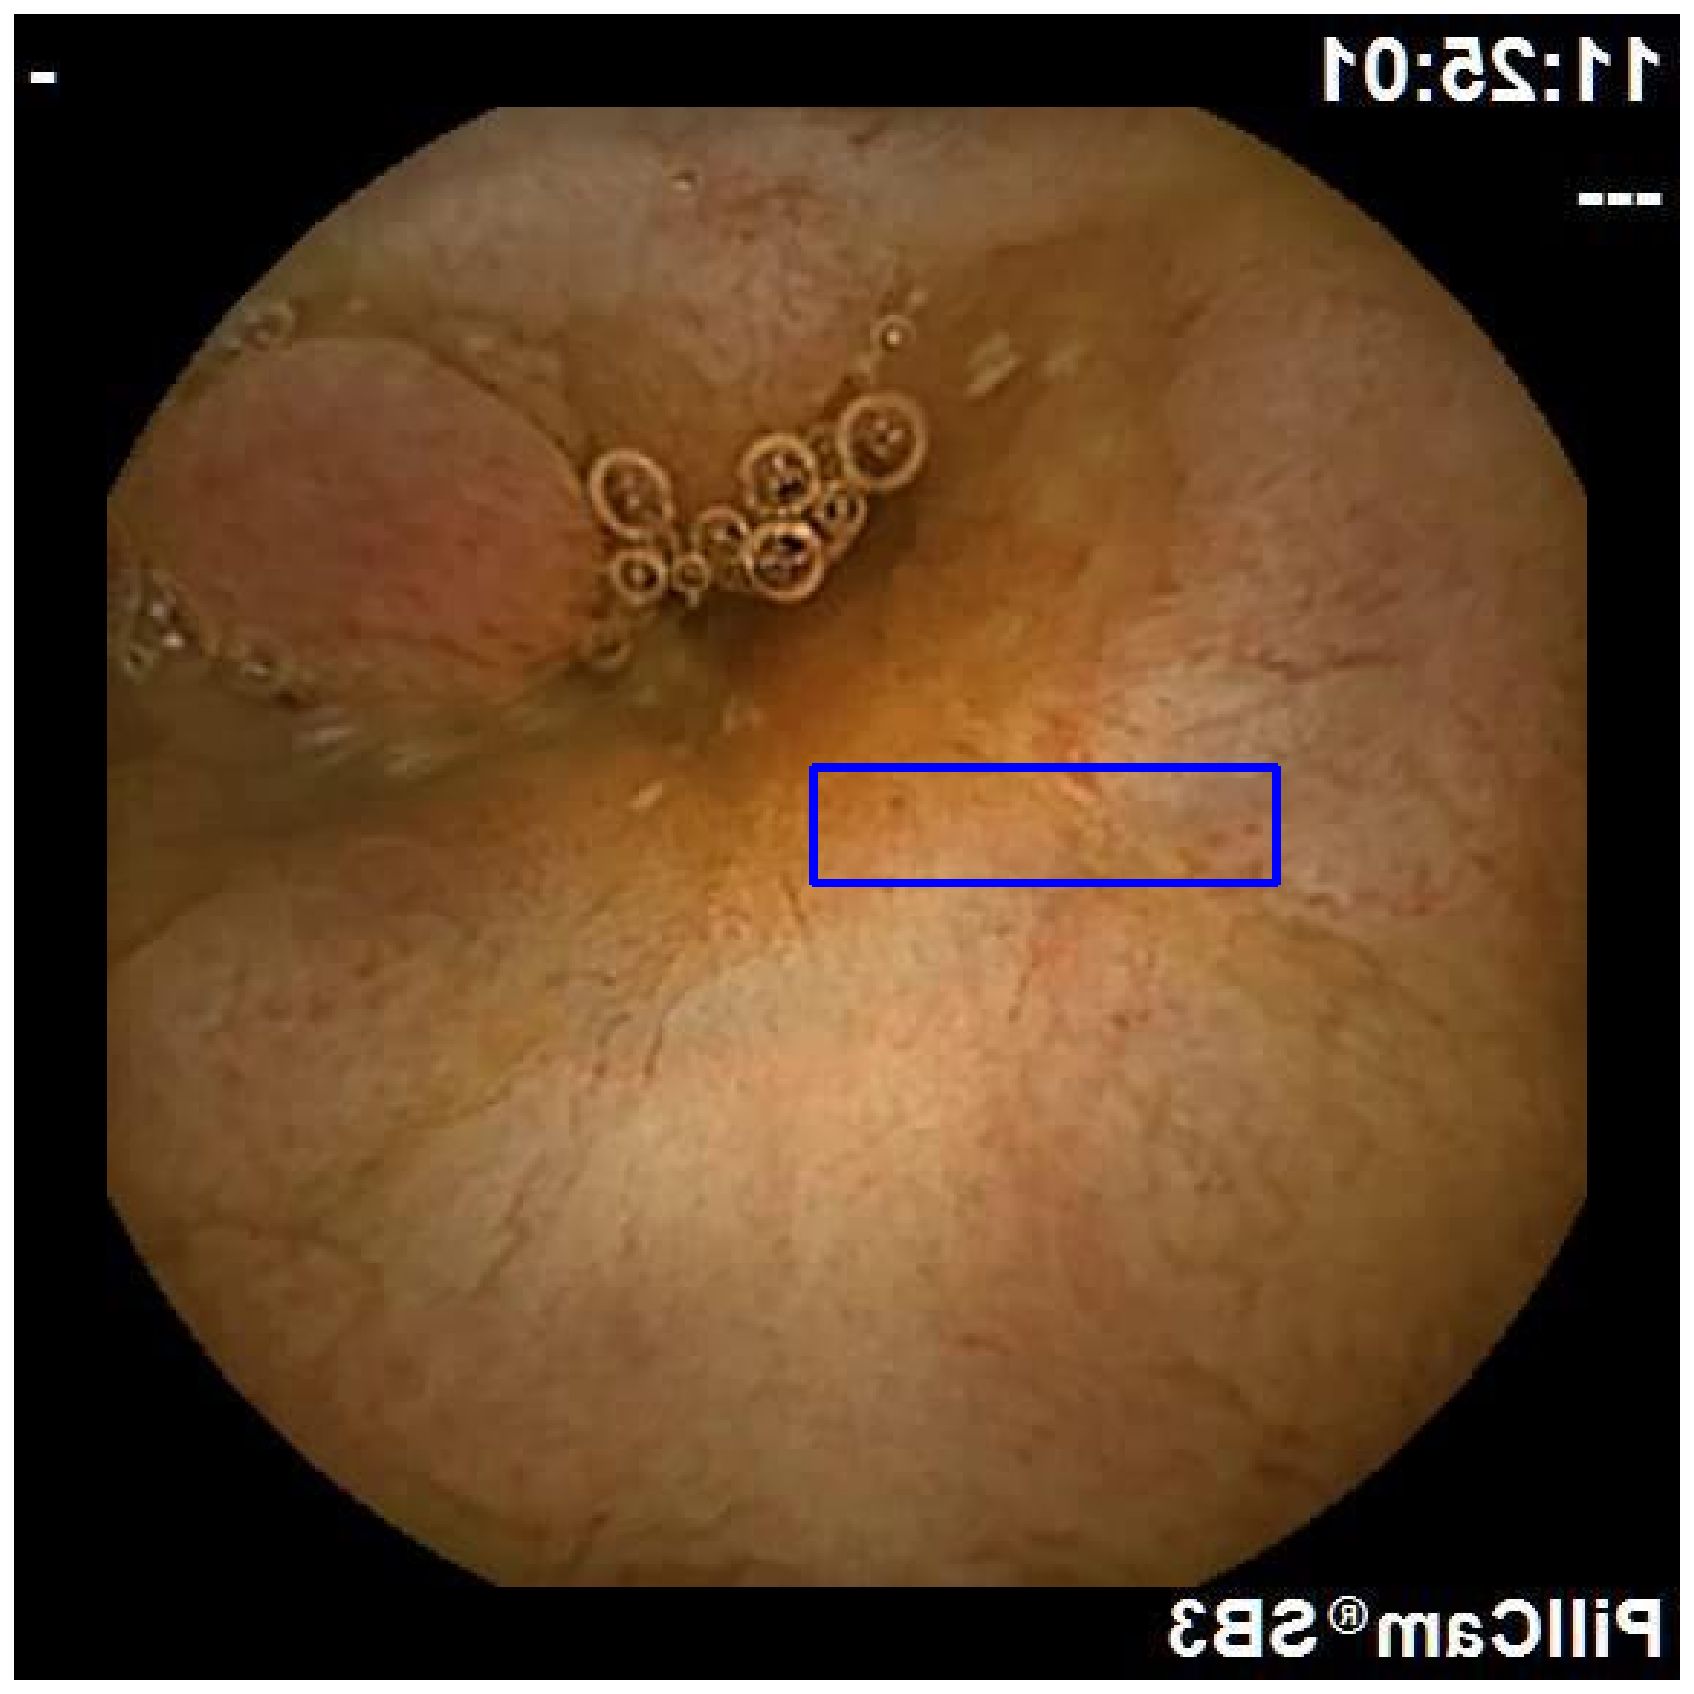

In [219]:
# Flip
aug = A.Compose([
    A.Flip(always_apply=True)
], bbox_params=bbox_params)

# 증강 보여주기
show_augmented(aug, form, BBOX)

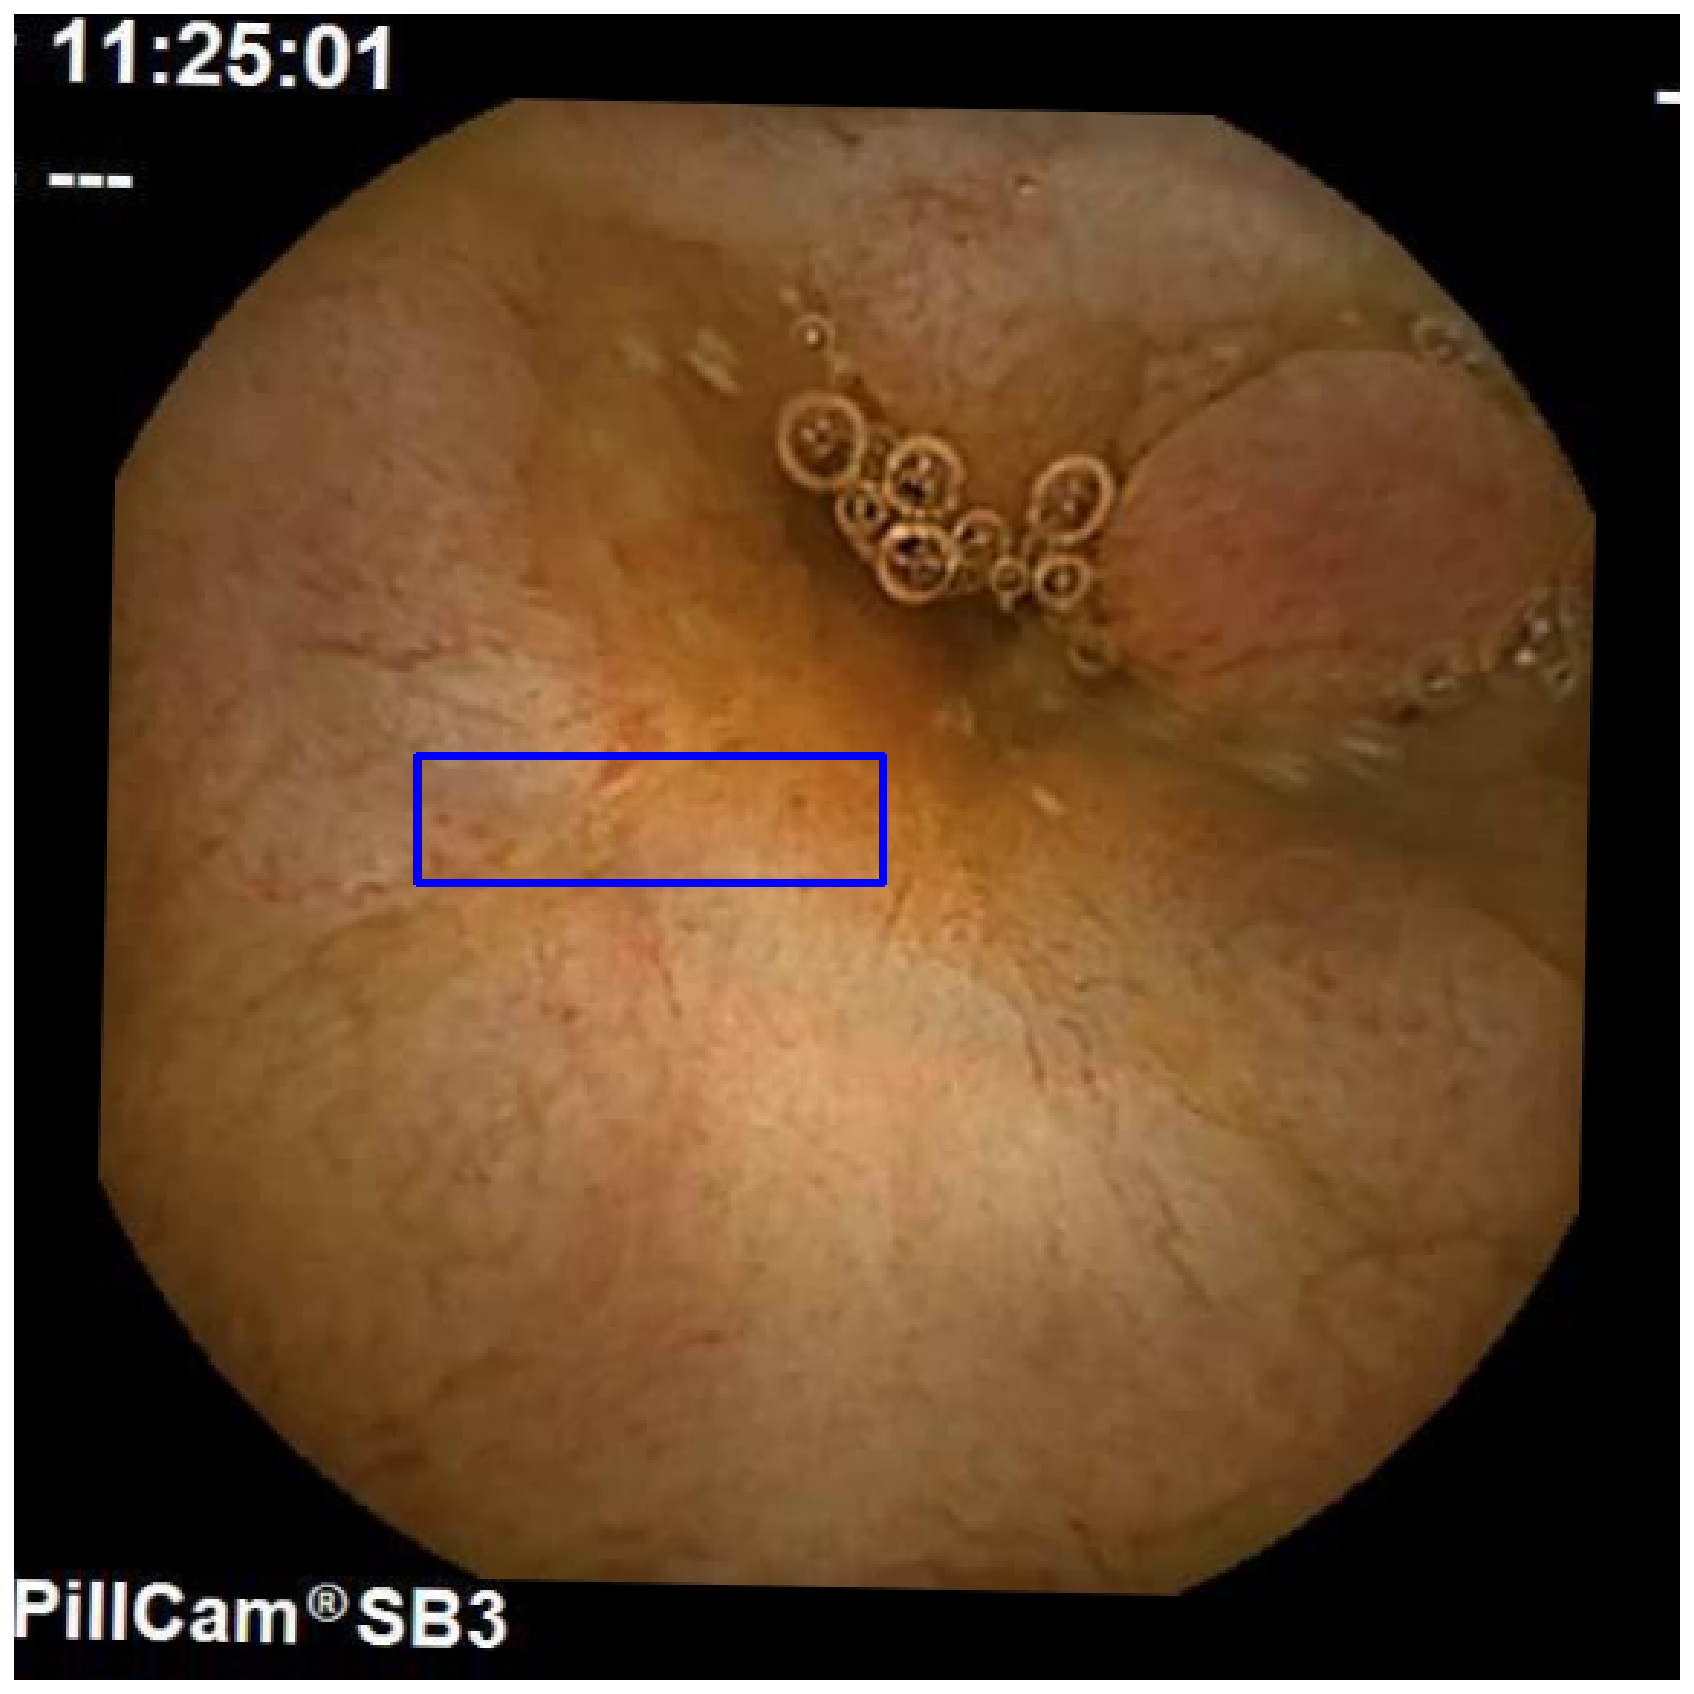

In [220]:
# Rotate
aug = A.Compose([
  A.Rotate(limit=80, always_apply=True)
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

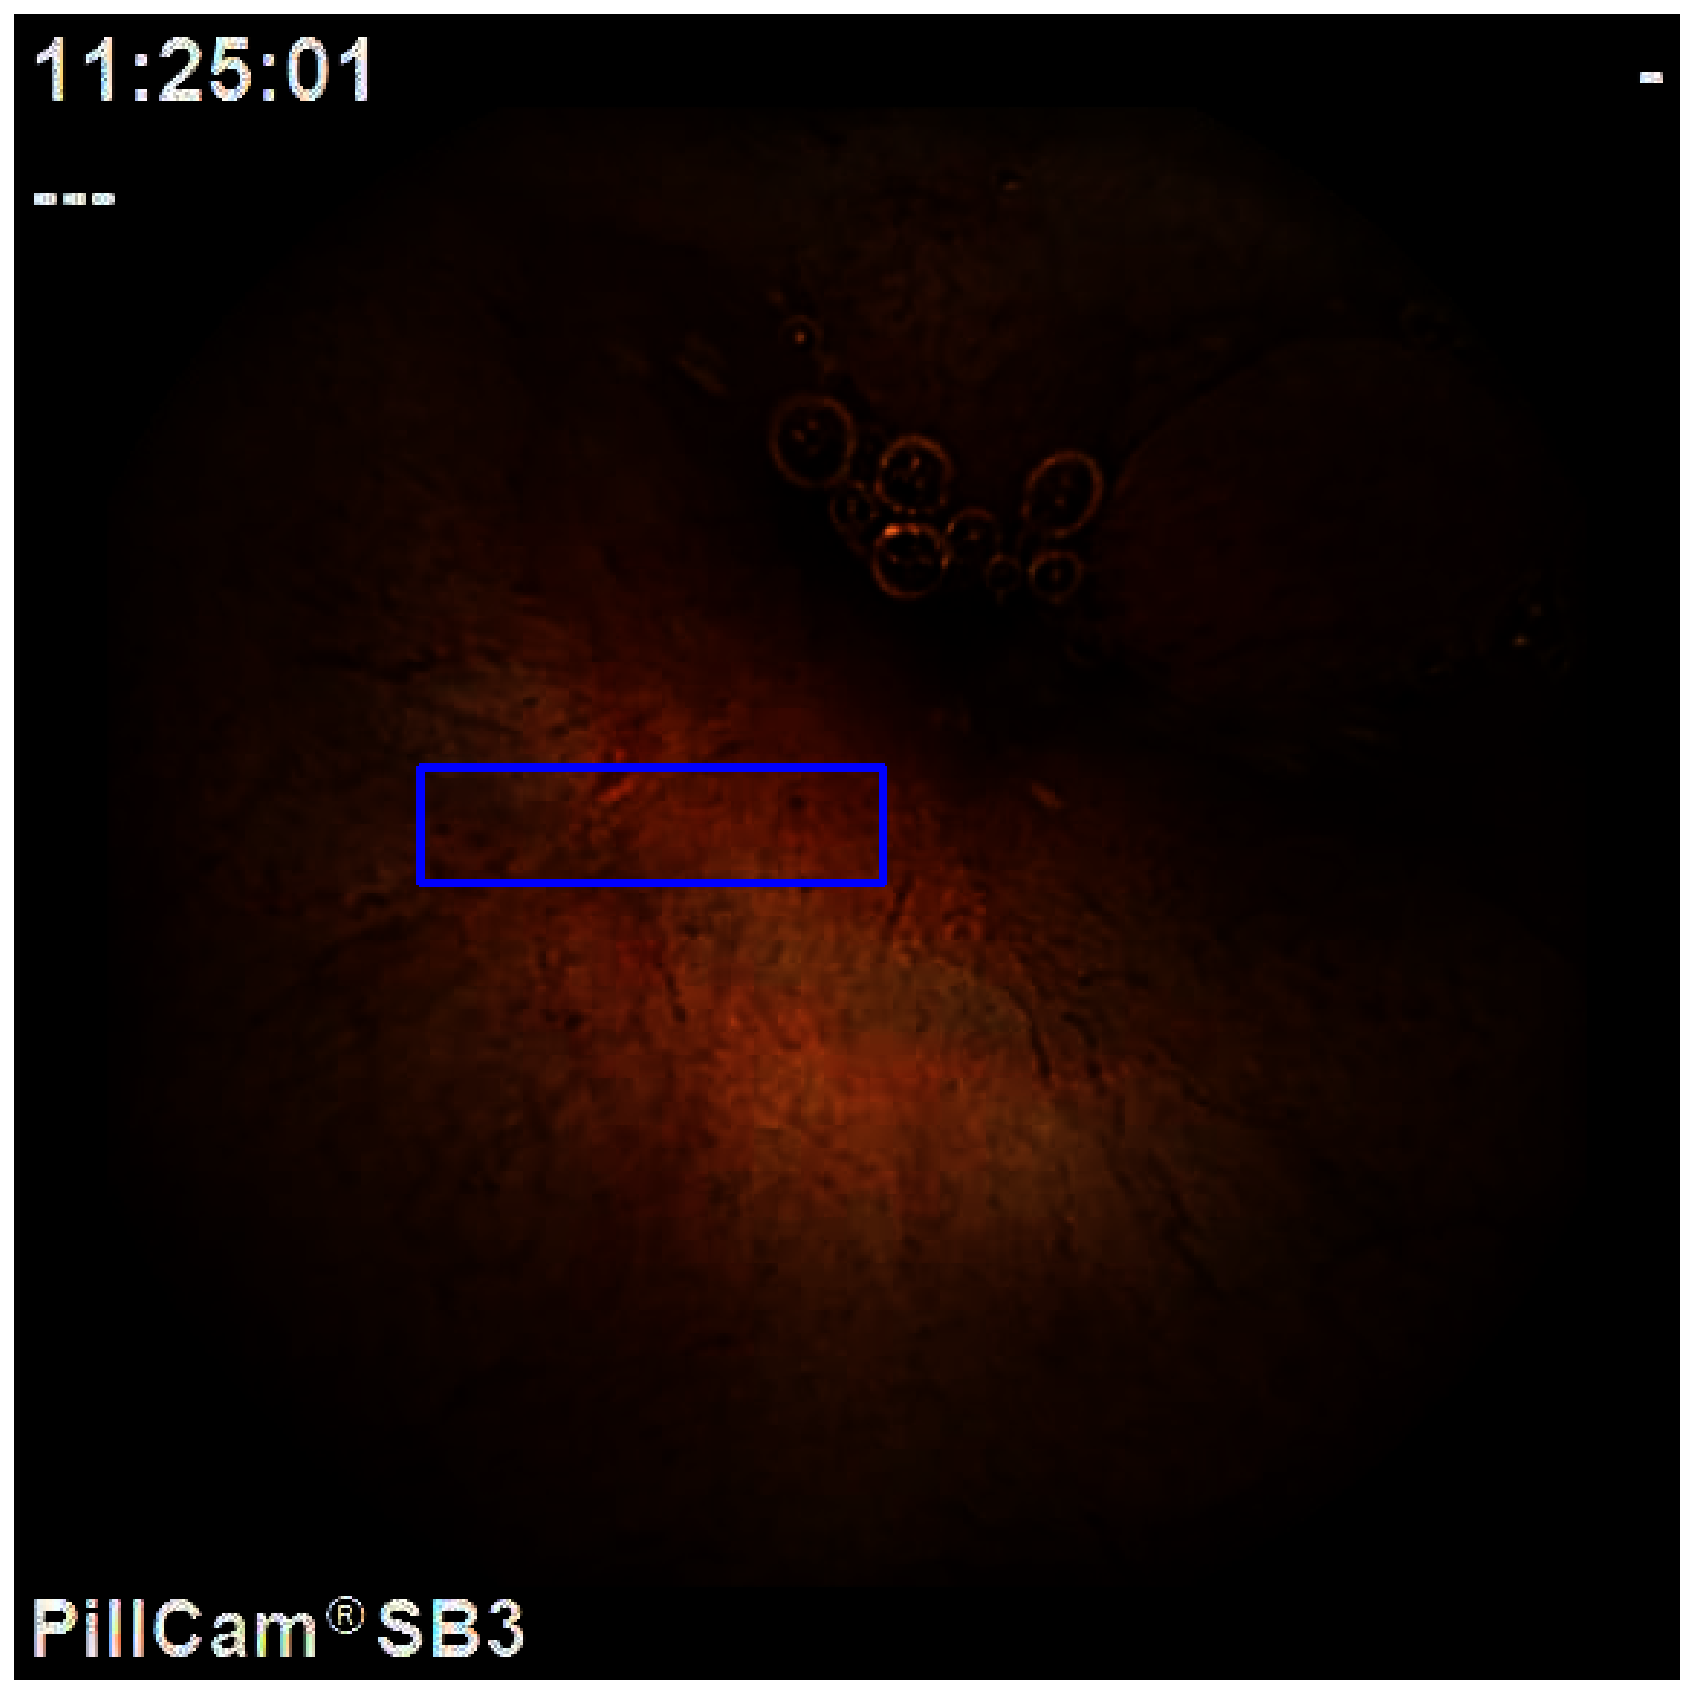

In [223]:
# RandomGamma
aug = A.Compose([
    A.RandomGamma(gamma_limit=(400, 500), always_apply=True)
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

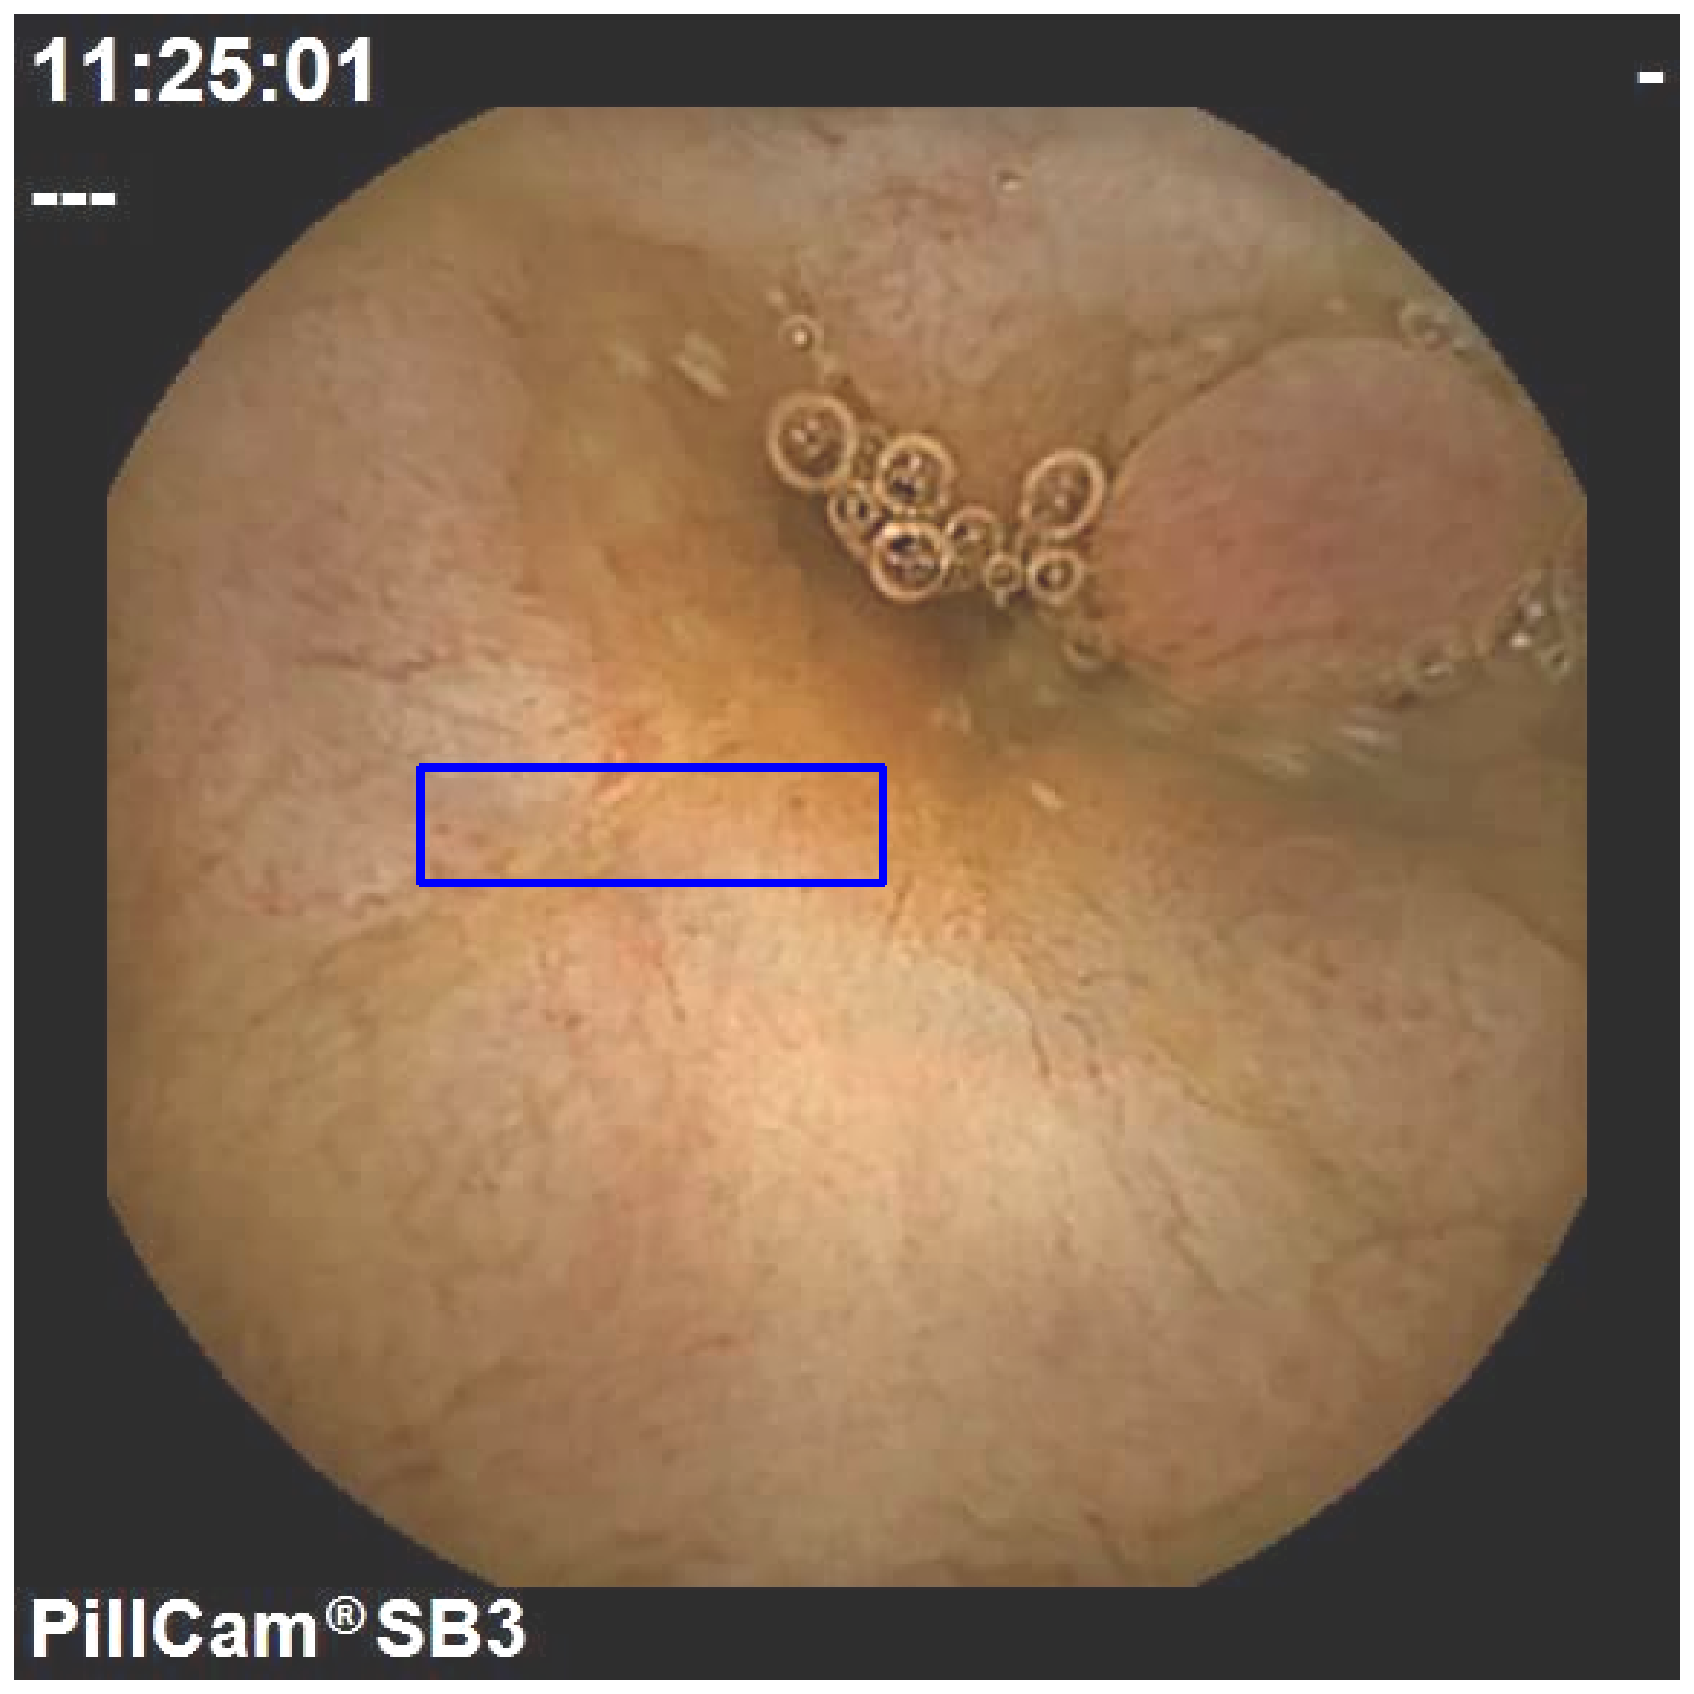

In [224]:
# RandomBrightnessContrast
aug = A.Compose([
    A.RandomBrightnessContrast(always_apply=True),
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

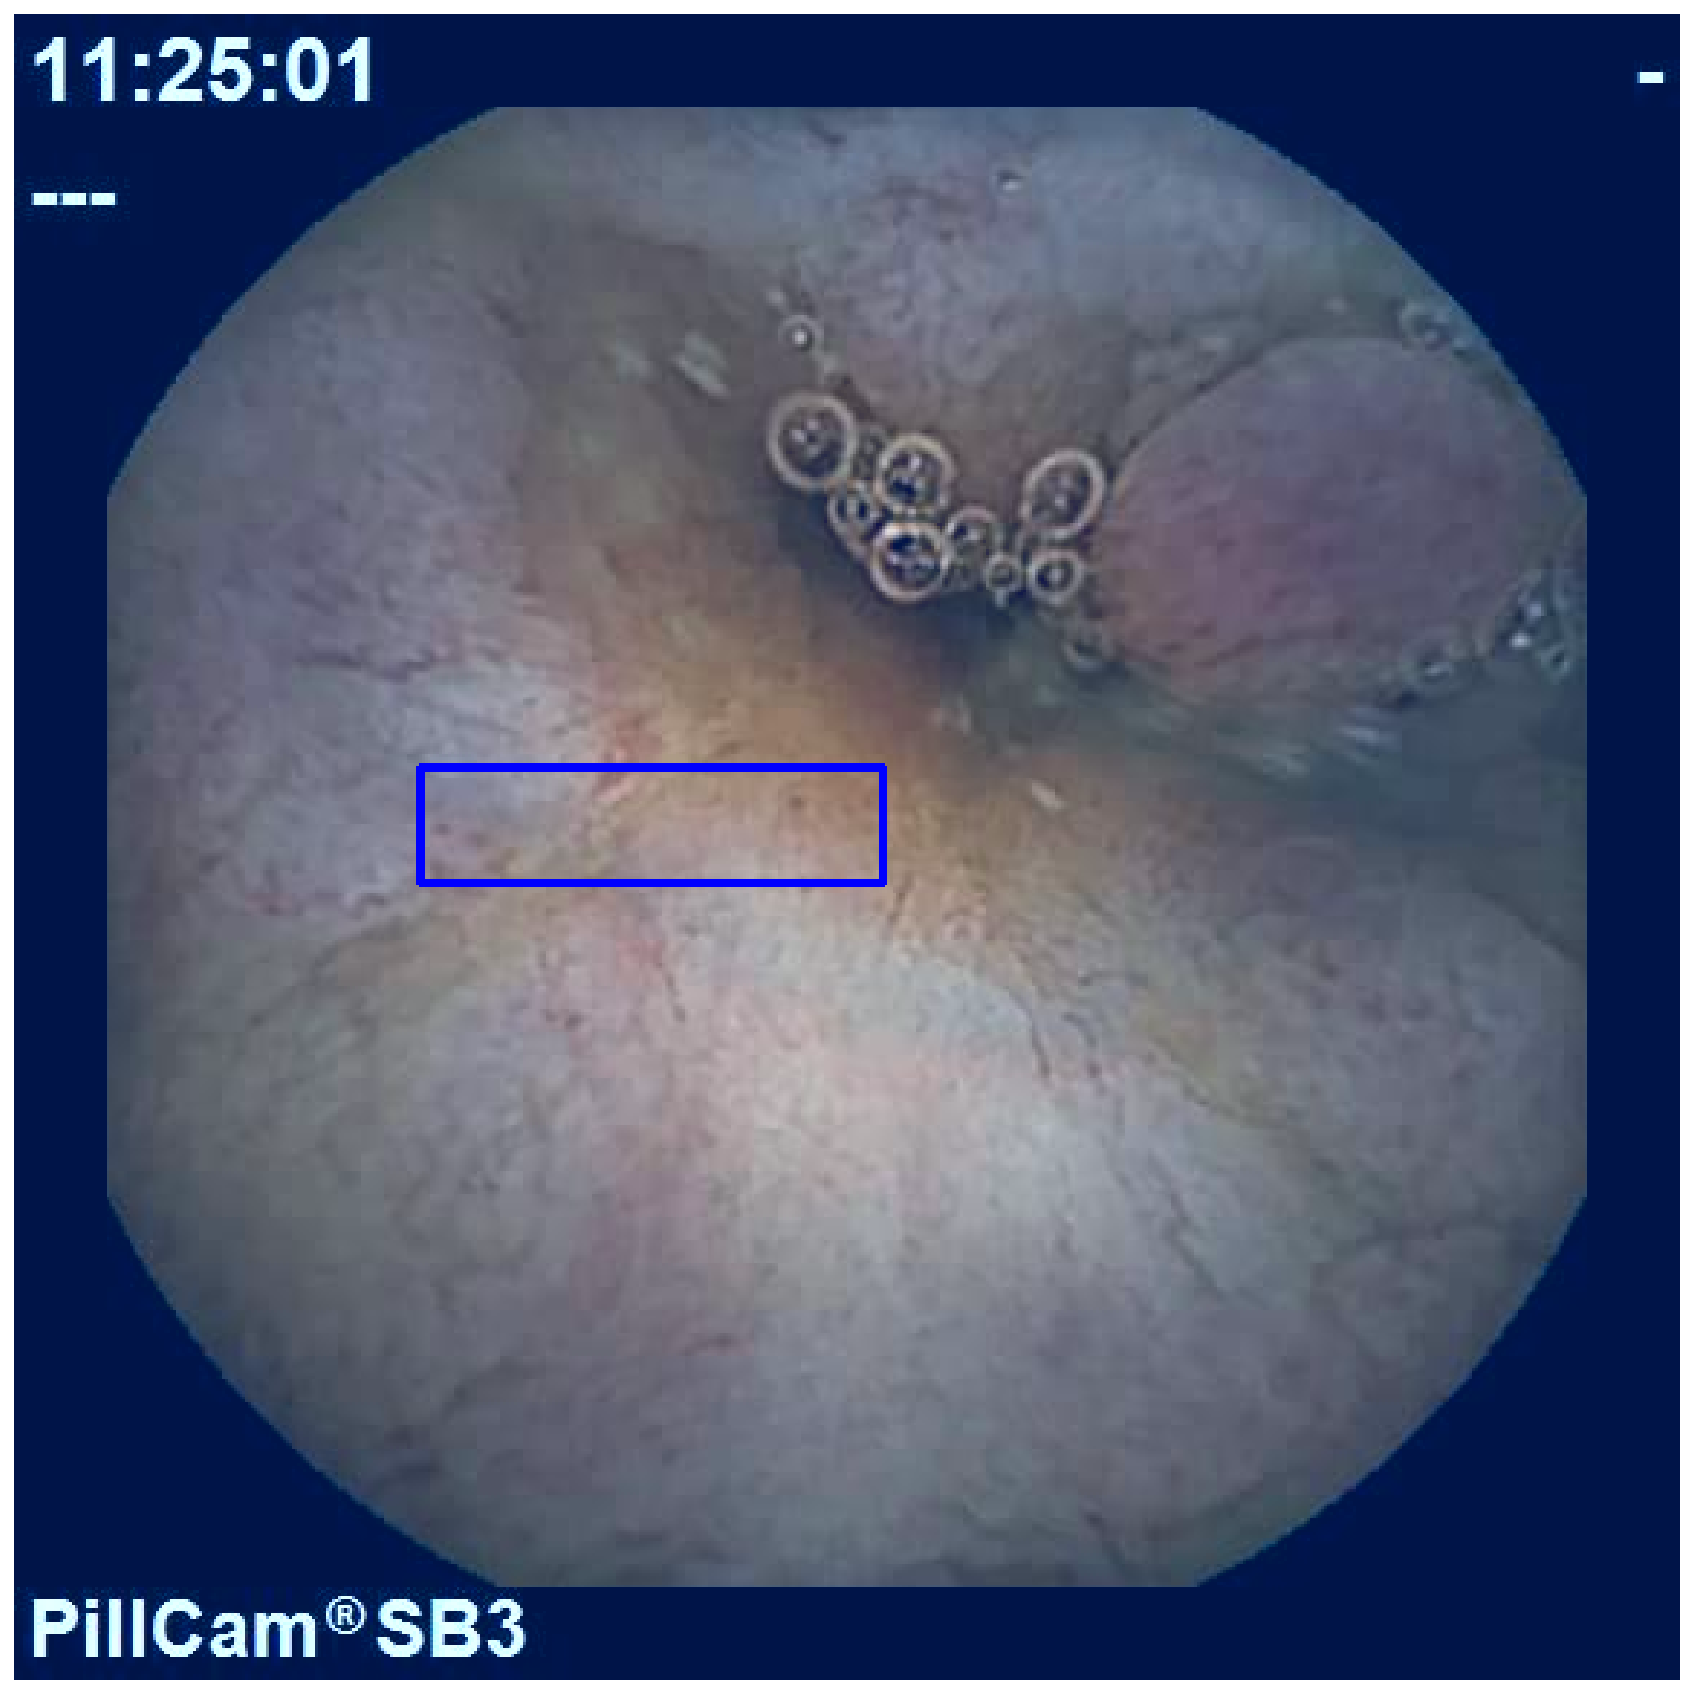

In [225]:
# RGBShift
aug = A.Compose([
    A.RGBShift(
      always_apply=True, 
      r_shift_limit=100, 
      g_shift_limit=100,
      b_shift_limit=100
    ),
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

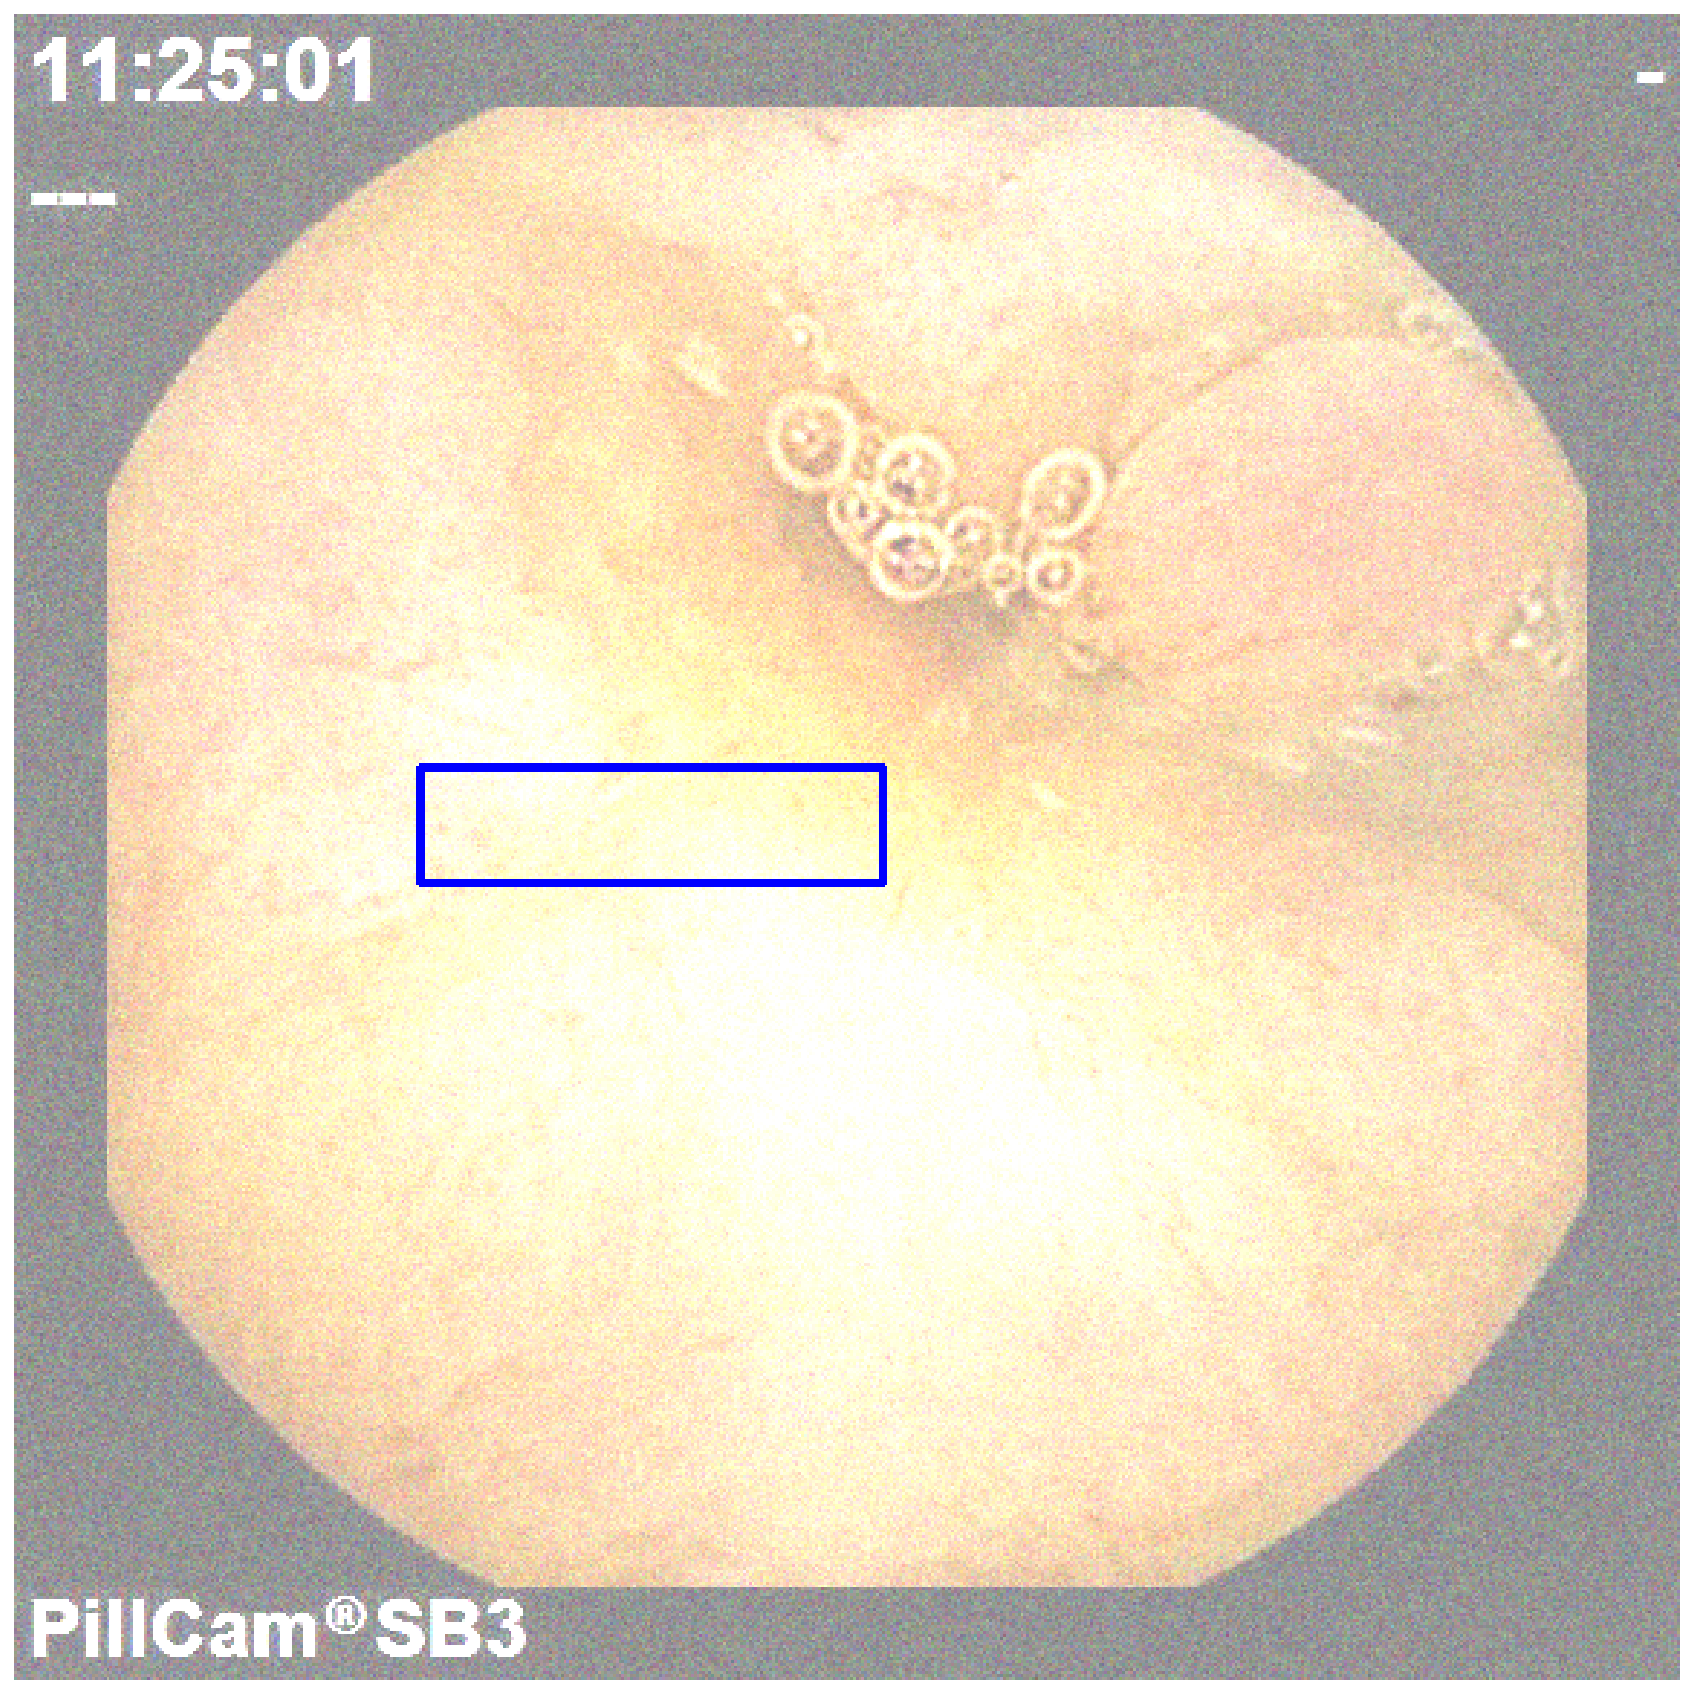

In [226]:
# GaussNoise
aug = A.Compose([
    A.GaussNoise(
      always_apply=True,
      var_limit=(100, 300),
      mean=150
    ),
], bbox_params=bbox_params)

# 증강 함수
show_augmented(aug, form, BBOX)

# Augmenting Scanned Documents

In [228]:
# 증강요소
doc_aug = A.Compose([
    A.Flip(p=0.25),
    A.RandomGamma(gamma_limit=(20, 300), p=0.5),
    A.RandomBrightnessContrast(p=0.85),
    A.Rotate(limit=35, p=0.9),
    A.RandomRotate90(p=0.25),
    A.RGBShift(p=0.75),
    A.GaussNoise(p=0.25)
], bbox_params=bbox_params)

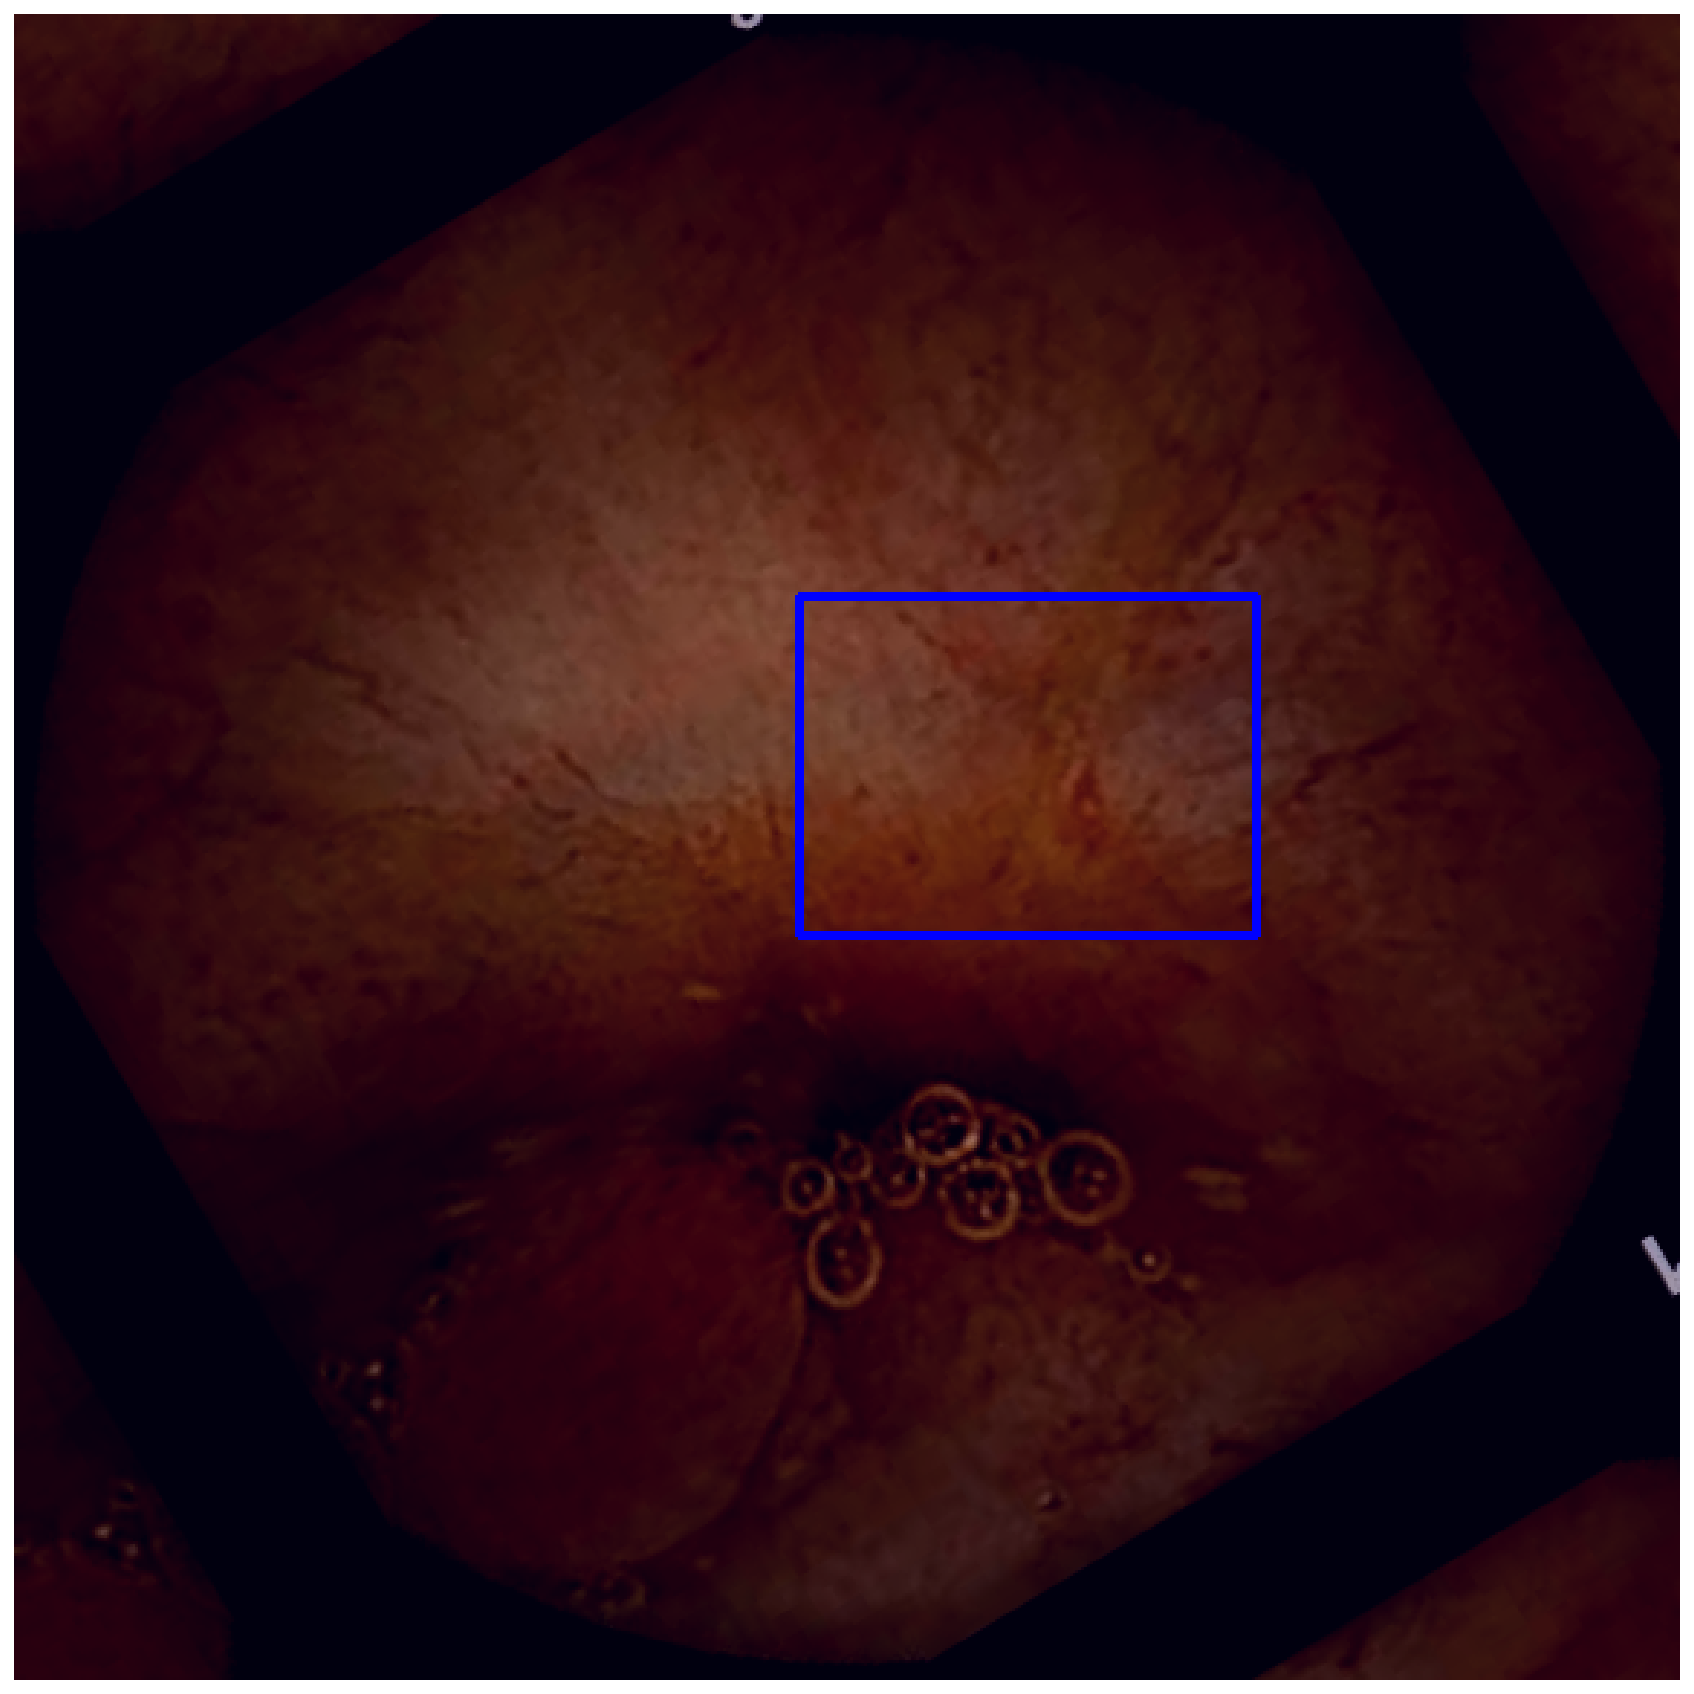

In [229]:
# 증강 함수
show_augmented(doc_aug, form, BBOX)


# Creating Augmented Dataset

Using the format:

`path/to/image.jpg,x1,y1,x2,y2,class_name`

In [230]:
DATASET_PATH = 'data/augmented'
IMAGES_PATH = f'{DATASET_PATH}/images'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

N=10
rows = []
for i in tqdm(range(N)):
  augmented = doc_aug(image=form, bboxes=[BBOX], field_id=['2'])
  file_name = f'form_aug_{i}.jpg'
  
  for bbox in augmented['bboxes']:
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    rows.append({
      'file_name': f'images/{file_name}',
      'x_min': x_min,
      'y_min': y_min,
      'x_max': x_max,
      'y_max': y_max,
      'class_name': '02_mass'
    })

  cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

pd.DataFrame(rows).to_csv(f'{DATASET_PATH}/annotations.csv', header=True, index=None)

100%|██████████| 10/10 [00:00<00:00, 44.87it/s]


In [ ]:
# 예시 그림과 bb box
file_name= mass_df.iloc[0]['file_name']
DIR_TRAIN = '/content/data_coco/train/'
print(DIR_TRAIN+file_name)
form = cv2.imread(DIR_TRAIN+file_name)
#BBOX = [140, 260, 300, 300]
BBox= []
BBox.append(float(mass_df.iloc[0]['x_min']))
BBox.append(float(mass_df.iloc[0]['y_min']))
BBox.append(float(mass_df.iloc[0]['x_max']))
BBox.append(float(mass_df.iloc[0]['y_max']))
print(BBox)

In [237]:
mass_df

image_id class_name  class_id     x_min     y_min     x_max     y_max  \
4       146246    02_mass         2  374.4979  110.8787  542.2803  241.0042   
6       159910    02_mass         2   33.5946   40.8108  273.0541  360.2703   
7       138037    02_mass         2  336.0000  324.4000  523.2000  483.6000   
9       116776    02_mass         2  119.3723  366.0996  228.8961  466.9654   
10      113157    02_mass         2  157.3333  343.5294  214.6863  418.5294   
...        ...        ...       ...       ...       ...       ...       ...   
1117    102432    02_mass         2  195.0962  103.6058  274.9038  164.1827   
1122    105599    02_mass         2  134.4934  329.9559  212.4670  392.5110   
1124    157316    02_mass         2  107.0866   39.9055  188.9764  132.8189   
1130    160400    02_mass         2   30.8756   34.3871  452.9954  471.7143   
1131    110448    02_mass         2  165.0000  252.4444  266.7778  352.8889   

      width  height         file_name  
4       576     576  train_146246.jpg  
6       576     576  train_159910.jpg  
7       576     576  train_138037.jpg  
9       576     576  train_116776.jpg  
10      576     576  train_113157.jpg  
...     ...     ...               ...  
1117    320     320  train_102432.jpg  
1122    576     576  train_105599.jpg  
1124    576     576  train_157316.jpg  
1130    576     576  train_160400.jpg  
1131    576     576  train_110448.jpg  

[148 rows x 10 columns]

In [247]:
DATASET_PATH = '/content/drive/MyDrive/augumentation'
IMAGES_PATH = f'{DATASET_PATH}/mass'

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for j,k in tqdm(enumerate(mass_df.iloc)):
  mass_file_name=k['file_name']
  mass_bbox=[]
  mass_bbox.append(float(k['x_min']))
  mass_bbox.append(float(k['y_min']))
  mass_bbox.append(float(k['x_max']))
  mass_bbox.append(float(k['y_max']))
  print(mass_file_name,mass_bbox)

  DIR_TRAIN = '/content/data_coco/train/'
  print(DIR_TRAIN+mass_file_name)
  mass_form = cv2.imread(DIR_TRAIN+mass_file_name)

  N=10
  for i in tqdm(range(N)):
    augmented = doc_aug(image=mass_form, bboxes=[mass_bbox], field_id=['2'])
    file_name = f'form_aug_{j}_{i}.jpg'
    
    for bbox in augmented['bboxes']:
      x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
      rows.append({
        'file_name': file_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max,
        'class_name': '02_mass'
      })
    cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])

rows_df=pd.DataFrame(rows)
rows_df.to_csv(f'{DATASET_PATH}/mass_annotations.csv', header=True, index=None)

0it [00:00, ?it/s]

train_146246.jpg [374.4979, 110.8787, 542.2803, 241.0042]
/content/data_coco/train/train_146246.jpg



100%|██████████| 10/10 [00:00<00:00, 34.12it/s]
1it [00:00,  3.28it/s]

train_159910.jpg [33.5946, 40.8108, 273.0541, 360.2703]
/content/data_coco/train/train_159910.jpg



100%|██████████| 10/10 [00:00<00:00, 52.15it/s]
2it [00:00,  4.07it/s]

train_138037.jpg [336.0, 324.4, 523.2, 483.6]
/content/data_coco/train/train_138037.jpg



100%|██████████| 10/10 [00:00<00:00, 32.85it/s]
3it [00:00,  3.60it/s]

train_116776.jpg [119.3723, 366.0996, 228.8961, 466.9654]
/content/data_coco/train/train_116776.jpg



100%|██████████| 10/10 [00:00<00:00, 26.33it/s]
4it [00:01,  3.10it/s]

train_113157.jpg [157.3333, 343.5294, 214.6863, 418.5294]
/content/data_coco/train/train_113157.jpg



100%|██████████| 10/10 [00:00<00:00, 33.17it/s]
5it [00:01,  3.13it/s]

train_113157.jpg [388.2157, 402.8431, 505.8627, 507.2549]
/content/data_coco/train/train_113157.jpg



100%|██████████| 10/10 [00:00<00:00, 34.99it/s]
6it [00:01,  3.20it/s]

train_128778.jpg [132.3431, 84.0638, 258.7854, 209.7849]
/content/data_coco/train/train_128778.jpg



100%|██████████| 10/10 [00:00<00:00, 84.91it/s]
7it [00:01,  3.98it/s]

train_102595.jpg [113.7446, 260.039, 238.4199, 378.2208]
/content/data_coco/train/train_102595.jpg



100%|██████████| 10/10 [00:00<00:00, 46.90it/s]
8it [00:02,  4.12it/s]

train_131121.jpg [245.0317, 49.2063, 418.8413, 185.3175]
/content/data_coco/train/train_131121.jpg



100%|██████████| 10/10 [00:00<00:00, 29.38it/s]
9it [00:02,  3.61it/s]

train_126400.jpg [90.6667, 207.7451, 171.0588, 299.4118]
/content/data_coco/train/train_126400.jpg



100%|██████████| 10/10 [00:00<00:00, 28.74it/s]
10it [00:02,  3.31it/s]

train_159372.jpg [270.4771, 418.4771, 341.1193, 495.5413]
/content/data_coco/train/train_159372.jpg



100%|██████████| 10/10 [00:00<00:00, 27.40it/s]
11it [00:03,  3.07it/s]

train_107708.jpg [165.8986, 36.6912, 542.8571, 474.9401]
/content/data_coco/train/train_107708.jpg



100%|██████████| 10/10 [00:00<00:00, 25.63it/s]
12it [00:03,  2.87it/s]

train_128527.jpg [285.1852, 192.9383, 429.6296, 308.9877]
/content/data_coco/train/train_128527.jpg



100%|██████████| 10/10 [00:00<00:00, 39.87it/s]
13it [00:03,  3.10it/s]

train_140771.jpg [329.5789, 386.5, 486.1579, 538.4737]
/content/data_coco/train/train_140771.jpg



100%|██████████| 10/10 [00:00<00:00, 38.06it/s]
14it [00:04,  3.24it/s]

train_107574.jpg [383.127, 252.0317, 467.254, 336.1587]
/content/data_coco/train/train_107574.jpg



100%|██████████| 10/10 [00:00<00:00, 29.78it/s]
15it [00:04,  3.12it/s]

train_138776.jpg [266.7406, 36.5994, 359.2478, 100.8646]
/content/data_coco/train/train_138776.jpg



100%|██████████| 10/10 [00:00<00:00, 39.96it/s]
16it [00:04,  3.30it/s]

train_114985.jpg [86.3239, 170.6901, 180.6901, 289.0]
/content/data_coco/train/train_114985.jpg



100%|██████████| 10/10 [00:00<00:00, 30.65it/s]
17it [00:05,  3.19it/s]

train_112843.jpg [39.4595, 242.8919, 178.0, 319.0]
/content/data_coco/train/train_112843.jpg



100%|██████████| 10/10 [00:00<00:00, 51.68it/s]
18it [00:05,  3.56it/s]

train_109542.jpg [9.3497, 162.3381, 184.3497, 308.0111]
/content/data_coco/train/train_109542.jpg



100%|██████████| 10/10 [00:00<00:00, 66.88it/s]
19it [00:05,  4.10it/s]

train_109542.jpg [116.3158, 79.3158, 230.0, 229.3158]
/content/data_coco/train/train_109542.jpg



100%|██████████| 10/10 [00:00<00:00, 84.13it/s]
20it [00:05,  4.78it/s]

train_161520.jpg [107.3684, 8.2632, 255.2632, 101.4211]
/content/data_coco/train/train_161520.jpg



100%|██████████| 10/10 [00:00<00:00, 56.12it/s]
21it [00:05,  4.94it/s]

train_115855.jpg [33.2941, 221.6555, 95.479, 316.6134]
/content/data_coco/train/train_115855.jpg



100%|██████████| 10/10 [00:00<00:00, 32.09it/s]
22it [00:06,  4.18it/s]

train_125488.jpg [33.2251, 81.2511, 176.5152, 313.7186]
/content/data_coco/train/train_125488.jpg



100%|██████████| 10/10 [00:00<00:00, 30.69it/s]
23it [00:06,  3.71it/s]

train_158737.jpg [33.1893, 136.6864, 193.5444, 329.5858]
/content/data_coco/train/train_158737.jpg



100%|██████████| 10/10 [00:00<00:00, 56.11it/s]
24it [00:06,  4.05it/s]

train_102084.jpg [259.6407, 492.2156, 299.7605, 526.3473]
/content/data_coco/train/train_102084.jpg



100%|██████████| 10/10 [00:00<00:00, 36.66it/s]
25it [00:06,  3.86it/s]

train_156059.jpg [3.0759, 88.6329, 194.2152, 251.9241]
/content/data_coco/train/train_156059.jpg



100%|██████████| 10/10 [00:00<00:00, 102.54it/s]
26it [00:07,  4.69it/s]

train_112088.jpg [29.4931, 30.2396, 294.0092, 334.3871]
/content/data_coco/train/train_112088.jpg



100%|██████████| 10/10 [00:00<00:00, 37.70it/s]
27it [00:07,  4.31it/s]

train_154254.jpg [256.6667, 146.6667, 348.6667, 260.0]
/content/data_coco/train/train_154254.jpg



100%|██████████| 10/10 [00:00<00:00, 31.90it/s]
28it [00:07,  3.83it/s]

train_124901.jpg [125.3736, 40.8462, 245.1538, 203.4835]
/content/data_coco/train/train_124901.jpg



100%|██████████| 10/10 [00:00<00:00, 33.55it/s]
29it [00:08,  3.63it/s]

train_124901.jpg [30.8681, 61.7253, 181.4176, 341.9451]
/content/data_coco/train/train_124901.jpg



100%|██████████| 10/10 [00:00<00:00, 37.30it/s]
30it [00:08,  3.61it/s]

train_121517.jpg [312.9032, 31.4654, 541.0138, 319.4839]
/content/data_coco/train/train_121517.jpg



100%|██████████| 10/10 [00:00<00:00, 26.40it/s]
31it [00:08,  3.20it/s]

train_150649.jpg [293.4632, 164.9351, 541.5152, 380.9524]
/content/data_coco/train/train_150649.jpg



100%|██████████| 10/10 [00:00<00:00, 26.22it/s]
32it [00:09,  2.97it/s]

train_152941.jpg [331.4554, 251.1362, 459.1549, 453.0141]
/content/data_coco/train/train_152941.jpg



100%|██████████| 10/10 [00:00<00:00, 32.29it/s]
33it [00:09,  3.01it/s]

train_158787.jpg [33.658, 111.987, 141.0173, 389.0433]
/content/data_coco/train/train_158787.jpg



100%|██████████| 10/10 [00:00<00:00, 30.00it/s]
34it [00:09,  2.97it/s]

train_131938.jpg [432.8462, 241.6154, 520.5385, 310.0769]
/content/data_coco/train/train_131938.jpg



100%|██████████| 10/10 [00:00<00:00, 24.80it/s]
35it [00:10,  2.78it/s]

train_113747.jpg [204.7115, 84.1346, 305.9135, 175.7212]
/content/data_coco/train/train_113747.jpg



100%|██████████| 10/10 [00:00<00:00, 106.09it/s]
36it [00:10,  3.53it/s]

train_126696.jpg [274.0933, 441.6839, 393.7824, 529.7668]
/content/data_coco/train/train_126696.jpg



100%|██████████| 10/10 [00:00<00:00, 22.81it/s]
37it [00:10,  3.00it/s]

train_112995.jpg [317.0789, 279.9211, 460.5, 402.2895]
/content/data_coco/train/train_112995.jpg



100%|██████████| 10/10 [00:00<00:00, 38.08it/s]
38it [00:10,  3.16it/s]

train_131110.jpg [50.1558, 306.0606, 125.4805, 370.9957]
/content/data_coco/train/train_131110.jpg



100%|██████████| 10/10 [00:00<00:00, 34.36it/s]
39it [00:11,  3.20it/s]

train_131110.jpg [87.8182, 161.9048, 194.7446, 277.4892]
/content/data_coco/train/train_131110.jpg



100%|██████████| 10/10 [00:00<00:00, 36.10it/s]
40it [00:11,  3.27it/s]

train_155204.jpg [235.8249, 93.4641, 317.4211, 185.4737]
/content/data_coco/train/train_155204.jpg



100%|██████████| 10/10 [00:00<00:00, 75.04it/s]
41it [00:11,  3.89it/s]

train_148646.jpg [81.3247, 147.619, 169.6364, 242.8571]
/content/data_coco/train/train_148646.jpg



100%|██████████| 10/10 [00:00<00:00, 31.68it/s]
42it [00:12,  3.60it/s]

train_148646.jpg [63.5758, 306.0606, 125.0476, 365.368]
/content/data_coco/train/train_148646.jpg



100%|██████████| 10/10 [00:00<00:00, 28.51it/s]
43it [00:12,  3.29it/s]

train_125055.jpg [224.4902, 218.5294, 346.0588, 300.8824]
/content/data_coco/train/train_125055.jpg



100%|██████████| 10/10 [00:00<00:00, 37.29it/s]
44it [00:12,  3.37it/s]

train_121021.jpg [39.515, 121.5569, 219.1557, 261.6766]
/content/data_coco/train/train_121021.jpg



100%|██████████| 10/10 [00:00<00:00, 25.68it/s]
45it [00:13,  3.03it/s]

train_147168.jpg [227.2143, 158.3095, 465.9048, 392.2381]
/content/data_coco/train/train_147168.jpg



100%|██████████| 10/10 [00:00<00:00, 32.47it/s]
46it [00:13,  3.06it/s]

train_118592.jpg [288.8305, 307.9661, 357.4746, 377.4576]
/content/data_coco/train/train_118592.jpg



100%|██████████| 10/10 [00:00<00:00, 64.29it/s]
47it [00:13,  3.58it/s]

train_132237.jpg [201.0, 280.8, 334.2, 383.2]
/content/data_coco/train/train_132237.jpg



100%|██████████| 10/10 [00:00<00:00, 37.80it/s]
48it [00:13,  3.59it/s]

train_125557.jpg [59.6362, 145.1286, 159.6362, 277.3402]
/content/data_coco/train/train_125557.jpg



100%|██████████| 10/10 [00:00<00:00, 94.50it/s]
49it [00:13,  4.35it/s]

train_141352.jpg [335.1538, 98.8592, 495.9231, 273.3077]
/content/data_coco/train/train_141352.jpg



100%|██████████| 10/10 [00:00<00:00, 27.50it/s]
50it [00:14,  3.65it/s]

train_147055.jpg [55.2162, 53.7838, 359.0, 364.5946]
/content/data_coco/train/train_147055.jpg



100%|██████████| 10/10 [00:00<00:00, 47.16it/s]
51it [00:14,  3.87it/s]

train_126207.jpg [422.8571, 113.7619, 531.9048, 439.9524]
/content/data_coco/train/train_126207.jpg



100%|██████████| 10/10 [00:00<00:00, 52.58it/s]
52it [00:14,  4.14it/s]

train_134080.jpg [267.4519, 106.0096, 319.0, 231.0]
/content/data_coco/train/train_134080.jpg



100%|██████████| 10/10 [00:00<00:00, 66.97it/s]
53it [00:14,  4.61it/s]

train_128938.jpg [106.0175, 275.7719, 313.9123, 458.2281]
/content/data_coco/train/train_128938.jpg



100%|██████████| 10/10 [00:00<00:00, 36.43it/s]
54it [00:15,  4.20it/s]

train_155042.jpg [211.3333, 246.0, 310.6667, 369.3333]
/content/data_coco/train/train_155042.jpg



100%|██████████| 10/10 [00:00<00:00, 54.93it/s]
55it [00:15,  4.46it/s]

train_102138.jpg [196.8808, 313.5695, 408.8013, 511.5828]
/content/data_coco/train/train_102138.jpg



100%|██████████| 10/10 [00:00<00:00, 30.12it/s]
56it [00:15,  3.84it/s]

train_146381.jpg [123.5763, 356.2712, 231.2034, 458.8136]
/content/data_coco/train/train_146381.jpg



100%|██████████| 10/10 [00:00<00:00, 31.33it/s]
57it [00:16,  3.55it/s]

train_154673.jpg [235.6291, 314.1603, 438.9404, 501.8067]
/content/data_coco/train/train_154673.jpg



100%|██████████| 10/10 [00:00<00:00, 37.68it/s]
58it [00:16,  3.57it/s]

train_158319.jpg [172.8889, 190.2778, 273.5833, 284.0278]
/content/data_coco/train/train_158319.jpg



100%|██████████| 10/10 [00:00<00:00, 30.09it/s]
59it [00:16,  3.33it/s]

train_158319.jpg [278.4444, 229.1667, 351.3611, 313.8889]
/content/data_coco/train/train_158319.jpg



100%|██████████| 10/10 [00:00<00:00, 37.49it/s]
60it [00:16,  3.41it/s]

train_135059.jpg [35.023, 33.0046, 383.871, 288.765]
/content/data_coco/train/train_135059.jpg



100%|██████████| 10/10 [00:00<00:00, 31.62it/s]
61it [00:17,  3.29it/s]

train_109111.jpg [278.6008, 142.6214, 428.3951, 289.9465]
/content/data_coco/train/train_109111.jpg



100%|██████████| 10/10 [00:00<00:00, 31.69it/s]
62it [00:17,  3.21it/s]

train_142294.jpg [41.3729, 268.9831, 124.4237, 385.9322]
/content/data_coco/train/train_142294.jpg



100%|██████████| 10/10 [00:00<00:00, 30.82it/s]
63it [00:17,  3.14it/s]

train_111567.jpg [31.4324, 110.5405, 310.3514, 517.5676]
/content/data_coco/train/train_111567.jpg



100%|██████████| 10/10 [00:00<00:00, 47.70it/s]
64it [00:18,  3.45it/s]

train_122766.jpg [170.0866, 113.4199, 499.5238, 471.4286]
/content/data_coco/train/train_122766.jpg



100%|██████████| 10/10 [00:00<00:00, 50.13it/s]
65it [00:18,  3.75it/s]

train_161537.jpg [0.1591, 33.1364, 228.5682, 235.9773]
/content/data_coco/train/train_161537.jpg



100%|██████████| 10/10 [00:00<00:00, 88.09it/s]
66it [00:18,  4.47it/s]

train_104474.jpg [214.1111, 263.5556, 341.2222, 351.5556]
/content/data_coco/train/train_104474.jpg



100%|██████████| 10/10 [00:00<00:00, 37.21it/s]
67it [00:18,  4.14it/s]

train_161338.jpg [55.7797, 206.2712, 137.9831, 288.4746]
/content/data_coco/train/train_161338.jpg



100%|██████████| 10/10 [00:00<00:00, 63.69it/s]
68it [00:19,  4.54it/s]

train_145201.jpg [0.625, 49.7596, 80.1923, 133.1731]
/content/data_coco/train/train_145201.jpg



100%|██████████| 10/10 [00:00<00:00, 75.78it/s]
69it [00:19,  5.09it/s]

train_128594.jpg [276.6667, 54.6667, 444.6667, 160.6667]
/content/data_coco/train/train_128594.jpg



100%|██████████| 10/10 [00:00<00:00, 35.97it/s]
70it [00:19,  4.45it/s]

train_128594.jpg [442.6667, 188.6667, 544.0, 426.6667]
/content/data_coco/train/train_128594.jpg



100%|██████████| 10/10 [00:00<00:00, 25.61it/s]
71it [00:19,  3.60it/s]

train_127541.jpg [32.5135, 168.9189, 234.1351, 455.4054]
/content/data_coco/train/train_127541.jpg



100%|██████████| 10/10 [00:00<00:00, 65.92it/s]
72it [00:20,  4.09it/s]

train_146796.jpg [106.8421, 14.5789, 252.6316, 109.8421]
/content/data_coco/train/train_146796.jpg



100%|██████████| 10/10 [00:00<00:00, 79.68it/s]
73it [00:20,  4.73it/s]

train_108719.jpg [227.5161, 175.3441, 399.0215, 300.0753]
/content/data_coco/train/train_108719.jpg



100%|██████████| 10/10 [00:00<00:00, 30.64it/s]
74it [00:20,  4.01it/s]

train_162572.jpg [31.7972, 32.8479, 496.3134, 332.3871]
/content/data_coco/train/train_162572.jpg



100%|██████████| 10/10 [00:00<00:00, 23.25it/s]
75it [00:20,  3.25it/s]

train_109491.jpg [117.2078, 233.1991, 262.2294, 374.3247]
/content/data_coco/train/train_109491.jpg



100%|██████████| 10/10 [00:00<00:00, 35.10it/s]
76it [00:21,  3.29it/s]

train_121161.jpg [325.5144, 188.823, 489.3004, 318.8642]
/content/data_coco/train/train_121161.jpg



100%|██████████| 10/10 [00:00<00:00, 40.03it/s]
77it [00:21,  3.43it/s]

train_133840.jpg [245.2381, 337.0952, 499.0476, 471.381]
/content/data_coco/train/train_133840.jpg



100%|██████████| 10/10 [00:00<00:00, 25.93it/s]
78it [00:21,  3.09it/s]

train_156653.jpg [322.8462, 179.4615, 459.0, 330.2308]
/content/data_coco/train/train_156653.jpg



100%|██████████| 10/10 [00:00<00:00, 39.77it/s]
79it [00:22,  3.27it/s]

train_155037.jpg [108.2949, 31.1613, 411.9816, 166.6452]
/content/data_coco/train/train_155037.jpg



100%|██████████| 10/10 [00:00<00:00, 43.99it/s]
80it [00:22,  3.50it/s]

train_153457.jpg [229.4737, 81.3158, 295.2632, 156.0526]
/content/data_coco/train/train_153457.jpg



100%|██████████| 10/10 [00:00<00:00, 60.67it/s]
81it [00:22,  3.96it/s]

train_132493.jpg [150.5411, 259.6061, 281.2771, 394.2381]
/content/data_coco/train/train_132493.jpg



100%|██████████| 10/10 [00:00<00:00, 36.14it/s]
82it [00:22,  3.79it/s]

train_116491.jpg [106.9124, 31.6221, 401.8433, 114.5714]
/content/data_coco/train/train_116491.jpg



100%|██████████| 10/10 [00:00<00:00, 27.20it/s]
83it [00:23,  3.35it/s]

train_101057.jpg [32.2581, 32.0829, 540.553, 402.129]
/content/data_coco/train/train_101057.jpg



100%|██████████| 10/10 [00:00<00:00, 25.63it/s]
84it [00:23,  3.03it/s]

train_122798.jpg [167.2115, 147.1154, 223.9423, 224.0385]
/content/data_coco/train/train_122798.jpg



100%|██████████| 10/10 [00:00<00:00, 64.59it/s]
85it [00:23,  3.57it/s]

train_158691.jpg [305.3333, 266.0, 480.6667, 465.3333]
/content/data_coco/train/train_158691.jpg



100%|██████████| 10/10 [00:00<00:00, 41.21it/s]
86it [00:24,  3.67it/s]

train_117002.jpg [30.8756, 34.8479, 410.1382, 542.682]
/content/data_coco/train/train_117002.jpg



100%|██████████| 10/10 [00:00<00:00, 26.58it/s]
87it [00:24,  3.26it/s]

train_147714.jpg [5.9796, 209.2857, 98.3265, 302.6531]
/content/data_coco/train/train_147714.jpg



100%|██████████| 10/10 [00:00<00:00, 59.29it/s]
88it [00:24,  3.72it/s]

train_119418.jpg [326.7992, 165.6904, 508.8075, 316.7364]
/content/data_coco/train/train_119418.jpg



100%|██████████| 10/10 [00:00<00:00, 23.20it/s]
89it [00:25,  3.12it/s]

train_151498.jpg [164.3269, 116.3462, 315.0481, 244.9519]
/content/data_coco/train/train_151498.jpg



100%|██████████| 10/10 [00:00<00:00, 70.77it/s]
90it [00:25,  3.70it/s]

train_151498.jpg [7.8947, 0.8947, 188.4211, 129.8421]
/content/data_coco/train/train_151498.jpg



100%|██████████| 10/10 [00:00<00:00, 71.82it/s]
91it [00:25,  4.28it/s]

train_123176.jpg [185.8132, 316.6703, 270.4286, 406.7802]
/content/data_coco/train/train_123176.jpg



100%|██████████| 10/10 [00:00<00:00, 37.92it/s]
92it [00:25,  4.07it/s]

train_129307.jpg [32.7485, 103.4795, 102.3392, 208.7427]
/content/data_coco/train/train_129307.jpg



100%|██████████| 10/10 [00:00<00:00, 69.65it/s]
93it [00:25,  4.57it/s]

train_123422.jpg [158.2222, 62.2222, 221.3333, 92.4444]
/content/data_coco/train/train_123422.jpg



100%|██████████| 10/10 [00:00<00:00, 28.25it/s]
94it [00:26,  3.80it/s]

train_114821.jpg [300.4805, 340.5972, 534.2553, 528.0145]
/content/data_coco/train/train_114821.jpg



100%|██████████| 10/10 [00:00<00:00, 37.28it/s]
95it [00:26,  3.72it/s]

train_100454.jpg [218.1681, 31.7395, 322.3697, 88.042]
/content/data_coco/train/train_100454.jpg



100%|██████████| 10/10 [00:00<00:00, 34.83it/s]
96it [00:26,  3.60it/s]

train_107250.jpg [32.0497, 122.2068, 235.5129, 345.8808]
/content/data_coco/train/train_107250.jpg



100%|██████████| 10/10 [00:00<00:00, 32.91it/s]
97it [00:27,  3.45it/s]

train_113982.jpg [32.7189, 33.0046, 286.6359, 168.9493]
/content/data_coco/train/train_113982.jpg



100%|██████████| 10/10 [00:00<00:00, 35.46it/s]
98it [00:27,  3.43it/s]

train_159153.jpg [300.0, 166.1893, 490.535, 312.2798]
/content/data_coco/train/train_159153.jpg



100%|██████████| 10/10 [00:00<00:00, 24.51it/s]
99it [00:27,  3.03it/s]

train_129510.jpg [31.4324, 86.7568, 300.0811, 528.3784]
/content/data_coco/train/train_129510.jpg



100%|██████████| 10/10 [00:00<00:00, 35.70it/s]
100it [00:28,  3.14it/s]

train_109558.jpg [226.9661, 222.3729, 291.3729, 305.4237]
/content/data_coco/train/train_109558.jpg



100%|██████████| 10/10 [00:00<00:00, 36.11it/s]
101it [00:28,  3.23it/s]

train_144699.jpg [299.177, 124.9259, 461.7284, 277.6008]
/content/data_coco/train/train_144699.jpg



100%|██████████| 10/10 [00:00<00:00, 50.78it/s]
102it [00:28,  3.57it/s]

train_100564.jpg [205.0866, 241.4242, 318.0736, 359.1732]
/content/data_coco/train/train_100564.jpg



100%|██████████| 10/10 [00:00<00:00, 37.82it/s]
103it [00:28,  3.59it/s]

train_125000.jpg [297.1193, 199.8765, 395.8848, 303.9918]
/content/data_coco/train/train_125000.jpg



100%|██████████| 10/10 [00:00<00:00, 36.69it/s]
104it [00:29,  3.57it/s]

train_124803.jpg [310.3333, 281.7778, 400.1111, 358.6667]
/content/data_coco/train/train_124803.jpg



100%|██████████| 10/10 [00:00<00:00, 31.31it/s]
105it [00:29,  3.38it/s]

train_157051.jpg [370.7819, 167.8354, 537.037, 326.2716]
/content/data_coco/train/train_157051.jpg



100%|██████████| 10/10 [00:00<00:00, 29.94it/s]
106it [00:29,  3.22it/s]

train_104868.jpg [212.6442, 86.2981, 294.375, 179.5673]
/content/data_coco/train/train_104868.jpg



100%|██████████| 10/10 [00:00<00:00, 73.23it/s]
107it [00:29,  3.82it/s]

train_106227.jpg [299.2511, 64.3172, 438.4581, 182.3789]
/content/data_coco/train/train_106227.jpg



100%|██████████| 10/10 [00:00<00:00, 34.08it/s]
108it [00:30,  3.64it/s]

train_107348.jpg [76.898, 220.5102, 202.0, 319.0]
/content/data_coco/train/train_107348.jpg



100%|██████████| 10/10 [00:00<00:00, 57.27it/s]
109it [00:30,  4.02it/s]

train_154780.jpg [354.9524, 192.8571, 481.5397, 328.9683]
/content/data_coco/train/train_154780.jpg



100%|██████████| 10/10 [00:00<00:00, 27.28it/s]
110it [00:30,  3.47it/s]

train_100594.jpg [165.4378, 246.3687, 543.7788, 544.5253]
/content/data_coco/train/train_100594.jpg



100%|██████████| 10/10 [00:00<00:00, 32.64it/s]
111it [00:31,  3.36it/s]

train_111448.jpg [73.1176, 96.3262, 274.7219, 323.0642]
/content/data_coco/train/train_111448.jpg



100%|██████████| 10/10 [00:00<00:00, 26.59it/s]
112it [00:31,  3.08it/s]

train_103571.jpg [80.0, 68.6842, 139.4737, 116.0526]
/content/data_coco/train/train_103571.jpg



100%|██████████| 10/10 [00:00<00:00, 134.73it/s]


train_113105.jpg [244.2396, 218.7189, 542.8571, 542.682]
/content/data_coco/train/train_113105.jpg



100%|██████████| 10/10 [00:00<00:00, 36.67it/s]
114it [00:31,  3.84it/s]

train_116766.jpg [37.1356, 252.0339, 123.5763, 357.1186]
/content/data_coco/train/train_116766.jpg



100%|██████████| 10/10 [00:00<00:00, 27.62it/s]
115it [00:32,  3.47it/s]

train_105715.jpg [269.0662, 320.1921, 439.9272, 471.1854]
/content/data_coco/train/train_105715.jpg



100%|██████████| 10/10 [00:00<00:00, 27.51it/s]
116it [00:32,  3.21it/s]

train_129896.jpg [384.2342, 236.0901, 455.8559, 329.3333]
/content/data_coco/train/train_129896.jpg



100%|██████████| 10/10 [00:00<00:00, 30.00it/s]
117it [00:32,  3.12it/s]

train_148178.jpg [79.0, 32.6757, 296.8378, 137.5405]
/content/data_coco/train/train_148178.jpg



100%|██████████| 10/10 [00:00<00:00, 34.75it/s]
118it [00:33,  3.18it/s]

train_148178.jpg [30.3514, 113.7568, 146.5676, 309.973]
/content/data_coco/train/train_148178.jpg



100%|██████████| 10/10 [00:00<00:00, 37.88it/s]
119it [00:33,  3.29it/s]

train_136411.jpg [46.4865, 232.6216, 186.0, 319.0]
/content/data_coco/train/train_136411.jpg



100%|██████████| 10/10 [00:00<00:00, 73.57it/s]
120it [00:33,  3.87it/s]

train_151489.jpg [304.7844, 310.7784, 382.0299, 395.8084]
/content/data_coco/train/train_151489.jpg



100%|██████████| 10/10 [00:00<00:00, 65.99it/s]
121it [00:33,  4.34it/s]

train_133332.jpg [235.2637, 416.6703, 327.5714, 513.3736]
/content/data_coco/train/train_133332.jpg



100%|██████████| 10/10 [00:00<00:00, 38.30it/s]
122it [00:34,  4.11it/s]

train_142851.jpg [104.2105, 36.6842, 235.2632, 210.8947]
/content/data_coco/train/train_142851.jpg



100%|██████████| 10/10 [00:00<00:00, 85.53it/s]
123it [00:34,  4.79it/s]

train_114456.jpg [268.9189, 223.4775, 349.5495, 335.1892]
/content/data_coco/train/train_114456.jpg



100%|██████████| 10/10 [00:00<00:00, 28.10it/s]
124it [00:34,  3.91it/s]

train_114456.jpg [220.2703, 259.5135, 292.7928, 366.7207]
/content/data_coco/train/train_114456.jpg



100%|██████████| 10/10 [00:00<00:00, 31.67it/s]
125it [00:34,  3.60it/s]

train_144247.jpg [192.5294, 65.2941, 340.7647, 180.0]
/content/data_coco/train/train_144247.jpg



100%|██████████| 10/10 [00:00<00:00, 31.70it/s]
126it [00:35,  3.42it/s]

train_148850.jpg [261.0117, 246.1988, 314.2281, 309.3567]
/content/data_coco/train/train_148850.jpg



100%|██████████| 10/10 [00:00<00:00, 21.63it/s]
127it [00:35,  2.88it/s]

train_160928.jpg [38.2488, 33.4654, 543.7788, 374.0184]
/content/data_coco/train/train_160928.jpg



100%|██████████| 10/10 [00:00<00:00, 20.66it/s]
128it [00:36,  2.55it/s]

train_154778.jpg [284.4444, 336.4444, 331.1111, 366.6667]
/content/data_coco/train/train_154778.jpg



100%|██████████| 10/10 [00:00<00:00, 31.46it/s]
129it [00:36,  2.67it/s]

train_156298.jpg [346.4576, 287.6271, 446.4576, 368.9831]
/content/data_coco/train/train_156298.jpg



100%|██████████| 10/10 [00:00<00:00, 31.40it/s]
130it [00:36,  2.77it/s]

train_127420.jpg [250.5443, 63.3165, 318.2658, 255.0886]
/content/data_coco/train/train_127420.jpg



100%|██████████| 10/10 [00:00<00:00, 63.96it/s]
131it [00:37,  3.30it/s]

train_106168.jpg [277.3663, 276.2428, 377.7778, 342.4979]
/content/data_coco/train/train_106168.jpg



100%|██████████| 10/10 [00:00<00:00, 46.06it/s]
132it [00:37,  3.56it/s]

train_116746.jpg [33.1797, 31.6221, 289.8618, 541.7604]
/content/data_coco/train/train_116746.jpg



100%|██████████| 10/10 [00:00<00:00, 38.89it/s]
133it [00:37,  3.60it/s]

train_124373.jpg [169.5853, 33.4654, 543.318, 543.6037]
/content/data_coco/train/train_124373.jpg



100%|██████████| 10/10 [00:00<00:00, 45.63it/s]
134it [00:37,  3.79it/s]

train_138537.jpg [268.3938, 320.9585, 358.5492, 395.5699]
/content/data_coco/train/train_138537.jpg



100%|██████████| 10/10 [00:00<00:00, 32.93it/s]
135it [00:38,  3.58it/s]

train_160607.jpg [390.0, 245.3333, 543.3333, 358.0]
/content/data_coco/train/train_160607.jpg



100%|██████████| 10/10 [00:00<00:00, 35.63it/s]
136it [00:38,  3.53it/s]

train_119413.jpg [246.8966, 352.2167, 312.4138, 443.8424]
/content/data_coco/train/train_119413.jpg



100%|██████████| 10/10 [00:00<00:00, 36.21it/s]
137it [00:38,  3.51it/s]

train_119413.jpg [183.8424, 423.1527, 290.2463, 517.734]
/content/data_coco/train/train_119413.jpg



100%|██████████| 10/10 [00:00<00:00, 38.09it/s]
138it [00:39,  3.55it/s]

train_152429.jpg [1.7042, 80.4366, 86.9155, 273.3944]
/content/data_coco/train/train_152429.jpg



100%|██████████| 10/10 [00:00<00:00, 70.48it/s]
139it [00:39,  4.11it/s]

train_159455.jpg [329.0323, 26.0922, 541.4747, 307.659]
/content/data_coco/train/train_159455.jpg



100%|██████████| 10/10 [00:00<00:00, 34.18it/s]
140it [00:39,  3.82it/s]

train_133218.jpg [144.0549, 210.0769, 246.2527, 351.8352]
/content/data_coco/train/train_133218.jpg



100%|██████████| 10/10 [00:00<00:00, 46.18it/s]
141it [00:39,  3.97it/s]

train_144779.jpg [335.2637, 432.0549, 452.8462, 537.5495]
/content/data_coco/train/train_144779.jpg



100%|██████████| 10/10 [00:00<00:00, 30.13it/s]
142it [00:40,  3.57it/s]

train_118129.jpg [99.2156, 150.501, 174.9367, 256.5106]
/content/data_coco/train/train_118129.jpg



100%|██████████| 10/10 [00:00<00:00, 76.16it/s]
143it [00:40,  4.19it/s]

train_102432.jpg [195.0962, 103.6058, 274.9038, 164.1827]
/content/data_coco/train/train_102432.jpg



100%|██████████| 10/10 [00:00<00:00, 83.64it/s]
144it [00:40,  4.87it/s]

train_105599.jpg [134.4934, 329.9559, 212.467, 392.511]
/content/data_coco/train/train_105599.jpg



100%|██████████| 10/10 [00:00<00:00, 25.16it/s]
145it [00:40,  3.75it/s]

train_157316.jpg [107.0866, 39.9055, 188.9764, 132.8189]
/content/data_coco/train/train_157316.jpg



100%|██████████| 10/10 [00:00<00:00, 24.20it/s]
146it [00:41,  3.18it/s]

train_160400.jpg [30.8756, 34.3871, 452.9954, 471.7143]
/content/data_coco/train/train_160400.jpg



100%|██████████| 10/10 [00:00<00:00, 38.92it/s]
147it [00:41,  3.32it/s]

train_110448.jpg [165.0, 252.4444, 266.7778, 352.8889]
/content/data_coco/train/train_110448.jpg



100%|██████████| 10/10 [00:00<00:00, 37.74it/s]
148it [00:41,  3.55it/s]
